# Model Credit Card Fraud Detection | EDA + ML Models
Proyek ini bertujuan untuk membangun sistem pendeteksi penipuan (fraud detection system) berbasis Machine Learning untuk transaksi kartu kredit.


## Load + Understand data

In [ ]:
!pip install category-encoders

In [ ]:
!pip install shap

In [ ]:
# =========================
# Core
# =========================
import os
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# (Optional) Plotly - pakai jika memang diperlukan
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# =========================
# Scikit-learn: split, preprocess, metrics
# =========================
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

# =========================
# Models
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# =========================
# Imbalanced-learn (SMOTE + Pipeline yang benar)
# =========================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# =========================
# Encoders (Target Encoding)
# =========================
import category_encoders as ce

# =========================
# Data source (optional)
# =========================
import kagglehub
import shap

In [ ]:
# Download latest version
path = kagglehub.dataset_download("chetanmittal033/credit-card-fraud-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'credit-card-fraud-data' dataset.
Path to dataset files: /kaggle/input/credit-card-fraud-data


In [ ]:
# Construct the full path to the CSV file within the downloaded dataset directory
dataset_file_path = os.path.join(path, 'fraudTest.csv')

# Load the dataset into a pandas DataFrame
df = pd.read_csv(dataset_file_path)
display(df.head())

,sn,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21-06-2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19-03-1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21-06-2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17-01-1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21-06-2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21-10-1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21-06-2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25-07-1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21-06-2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06-07-1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [ ]:
# df = pd.read_csv("/content/fraudTest.csv")
# df.head()

In [ ]:
# Shape
print("Dataset Shape:", df.shape)

#Info
df.info()

Dataset Shape: (555719, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sn                     555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long    

In [ ]:
#Ubah tanggal menjadi format datetime pilih
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], format="%d-%m-%Y %H:%M", errors="coerce")
df["dob"] = pd.to_datetime(df["dob"], format="%d-%m-%Y", errors="coerce")

# Time features
df['hour']  = df['trans_date_trans_time'].dt.hour
df['day']   = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

# Age (lebih akurat)
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days / 365.25

Time-based features and customer age were extracted from transaction timestamps and date of birth to capture behavioral patterns related to fraud.

In [ ]:
#Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   sn                     555719 non-null  int64         
 1   trans_date_trans_time  555719 non-null  datetime64[ns]
 2   cc_num                 555719 non-null  float64       
 3   merchant               555719 non-null  object        
 4   category               555719 non-null  object        
 5   amt                    555719 non-null  float64       
 6   first                  555719 non-null  object        
 7   last                   555719 non-null  object        
 8   gender                 555719 non-null  object        
 9   street                 555719 non-null  object        
 10  city                   555719 non-null  object        
 11  state                  555719 non-null  object        
 12  zip                    555719 non-null  int6

In [ ]:
df.head()

,sn,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,age
0,0,2020-06-21 12:14:00,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,12,21,6,52.257358
1,1,2020-06-21 12:14:00,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,12,21,6,30.425736
2,2,2020-06-21 12:14:00,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,12,21,6,49.667351
3,3,2020-06-21 12:15:00,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,12,21,6,32.908966
4,4,2020-06-21 12:15:00,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,12,21,6,64.960986


In [ ]:
# Check missing values

df.isnull().sum()

,0
sn,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,sn,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,age
count,555719.000000,555719,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,555719,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000
mean,277859.000000,2020-10-02 01:53:55.673389056,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1973-11-11 16:30:05.937173264,1.380679e+09,38.542798,-90.231380,0.003860,12.809062,16.463904,9.508536,46.887987
min,0.000000,2020-06-21 12:14:00,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1924-10-30 00:00:00,1.371817e+09,19.027422,-166.671575,0.000000,0.000000,1.000000,6.000000,15.392197
25%,138929.500000,2020-08-09 06:10:00,1.800430e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1962-09-27 00:00:00,1.376029e+09,34.755302,-96.905129,0.000000,7.000000,9.000000,8.000000,33.448323
50%,277859.000000,2020-10-03 00:59:00,3.521420e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1975-11-30 00:00:00,1.380762e+09,39.376593,-87.445204,0.000000,14.000000,17.000000,10.000000,44.908966
75%,416788.500000,2020-12-01 03:02:30,4.635330e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1987-04-23 00:00:00,1.385867e+09,41.954163,-80.264637,0.000000,19.000000,24.000000,12.000000,58.056126
max,555718.000000,2020-12-31 23:59:00,4.992350e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,2005-01-29 00:00:00,1.388534e+09,66.679297,-66.952026,1.000000,23.000000,31.000000,12.000000,96.169747
std,160422.401459,NaN,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,NaN,5.201104e+06,5.095829,13.733071,0.062008,6.810924,8.955311,1.978205,17.431204


data ini berisi 555.719 transaksi dengan 23 fitur dan tidak ada nilai yang hilang.

## Exploratory Data Analysis (EDA)

### Target Variable Distribution (Normal vs Fraud)

Menganalisis distribusi transaksi penipuan dan transaksi sah untuk memahami ketidakseimbangan kelas.

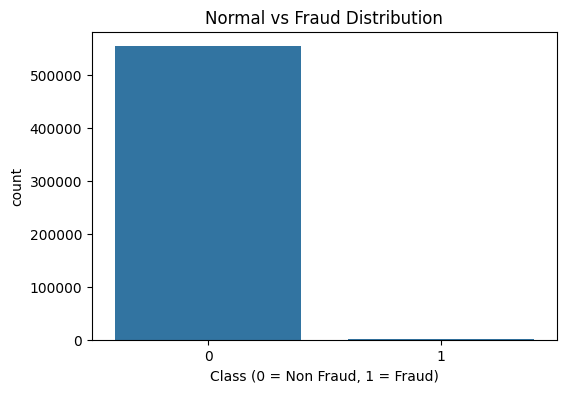


Normal transactions (Class 0): 553,574 (99.61%)
Fraud transactions (Class 1): 2,145 (0.39%)
Fraud ratio: 0.3875%
Imbalance ratio: 258.1:1


In [ ]:
#Visualisasi
plt.figure(figsize=(6,4))
sns.countplot(x=df['is_fraud'])
plt.title("Normal vs Fraud Distribution")
plt.xlabel("Class (0 = Non Fraud, 1 = Fraud)")
plt.show()

#Count
isfraud_counts = df['is_fraud'].value_counts()
fraud_ratio = isfraud_counts[1] / isfraud_counts[0] * 100
print(f"\nNormal transactions (Class 0): {isfraud_counts[0]:,} ({isfraud_counts[0]/len(df)*100:.2f}%)")
print(f"Fraud transactions (Class 1): {isfraud_counts[1]:,} ({isfraud_counts[1]/len(df)*100:.2f}%)")
print(f"Fraud ratio: {fraud_ratio:.4f}%")
print(f"Imbalance ratio: {isfraud_counts[0]/isfraud_counts[1]:.1f}:1")

In [ ]:
group_stats = df.groupby("is_fraud").mean(numeric_only=True)
group_stats

,sn,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,hour,day,month,age
is_fraud,,,,,,,,,,,,,,
0,277997.725990,4.179643e+17,67.614408,48846.424285,38.541406,-90.230495,88313.692365,1.380683e+09,38.540954,-90.230474,12.804107,16.469034,9.509982,46.879896
1,242057.088112,3.854275e+17,528.356494,47862.900233,39.019971,-90.445556,64529.321678,1.379587e+09,39.018618,-90.465222,14.087646,15.139860,9.135198,48.976043


Visualisasi dan output kode menunjukkan fenomena imbalance kelas yang sangat ekstrem. Dengan rasio 258 berbanding 1, transaksi penipuan (Fraud) hanyalah anomali yang mewakili kurang dari 0.4% populasi data (2.145 dari total lebih dari 555 ribu transaksi).


---
1. **Disparitas Signifikan pada Nominal (amt):** Terdapat perbedaan mencolok pada rata-rata nilai transaksi. Transaksi fraud memiliki rata-rata **528.35**, jauh lebih tinggi (~7.8x lipat) dibandingkan transaksi normal yang hanya **67.61**. Ini menunjukkan bahwa fraud cenderung menyasar nominal besar.
2. **Profil Demografi & Populasi (city_pop & age):**
* **city_pop:** Transaksi fraud rata-rata terjadi di wilayah dengan populasi lebih kecil (**64,529**) dibandingkan transaksi normal (**88,313**).
* **age:** Rata-rata usia korban fraud sedikit lebih tua (**48.9 tahun**) dibandingkan non-fraud (**46.8 tahun**), namun perbedaannya tidak terlalu signifikan secara statistik.
3. **Pola Temporal (hour):**
Rata-rata jam terjadinya fraud adalah pukul **14.08 (siang)**, sedikit lebih lambat dibandingkan transaksi normal di pukul **12.80**. Ini mengindikasikan adanya pergeseran waktu aktivitas pelaku.

### Amount vs Fraud

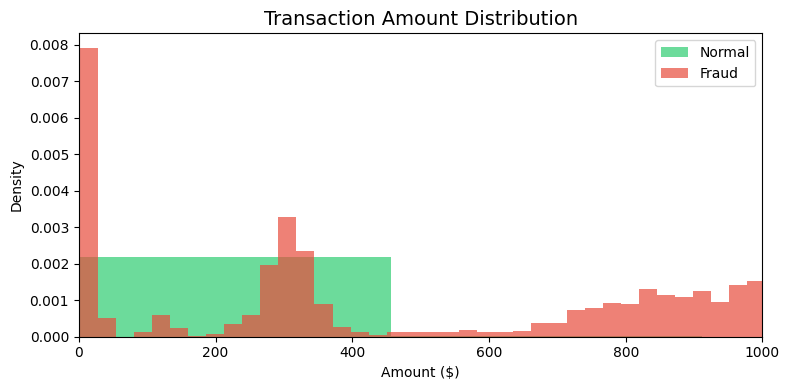

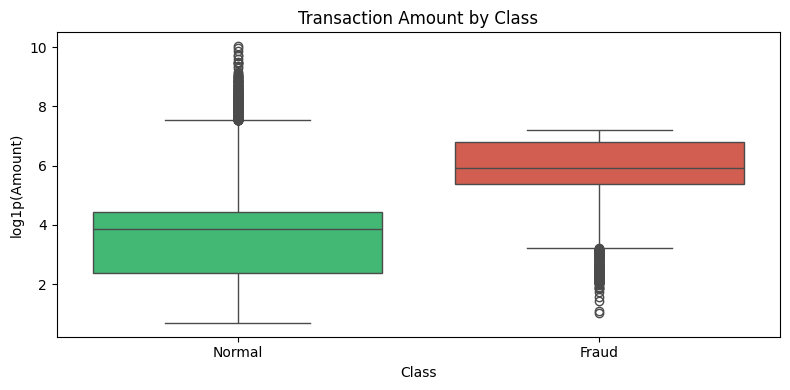

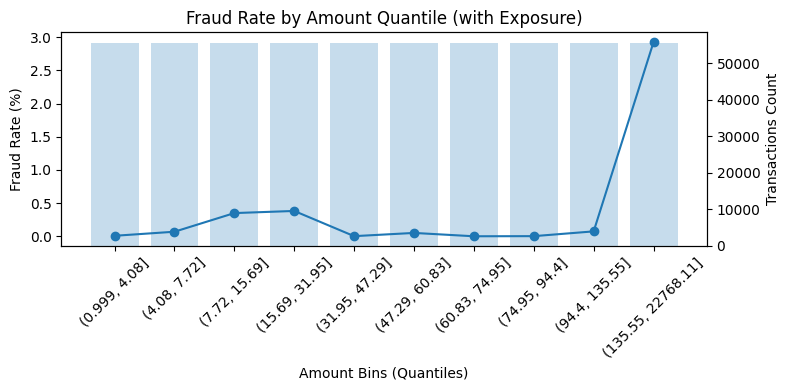

In [ ]:
# Transaction Amount Distribution
amount_fraud  = df.loc[df['is_fraud'] == 1, 'amt'].dropna()
amount_normal = df.loc[df['is_fraud'] == 0, 'amt'].dropna()

colors = ['#2ecc71', '#e74c3c']
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(amount_normal, bins=50, alpha=0.7, label='Normal', color=colors[0], density=True)
ax.hist(amount_fraud,  bins=50, alpha=0.7, label='Fraud',  color=colors[1], density=True)

ax.set_title('Transaction Amount Distribution', fontsize=14)
ax.set_xlabel('Amount ($)')
ax.set_ylabel('Density')
ax.legend()
ax.set_xlim(0, 1000)

plt.tight_layout()
plt.show()

# Transaction Amount by Class
df_plot = df[['is_fraud','amt']].copy()
df_plot['is_fraud'] = pd.to_numeric(df_plot['is_fraud'], errors='coerce')
df_plot['amt'] = pd.to_numeric(df_plot['amt'], errors='coerce')
df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna()
df_plot['class'] = df_plot['is_fraud'].map({0: 'Normal', 1: 'Fraud'})
df_plot['log_amt'] = np.log1p(df_plot['amt'])

colors = ['#2ecc71', '#e74c3c']
plt.figure(figsize=(8,4))
sns.boxplot(data=df_plot, x='class', y='log_amt', palette=colors,hue='class', legend=False)
plt.title('Transaction Amount by Class')
plt.xlabel('Class')
plt.ylabel('log1p(Amount)')
plt.tight_layout()
plt.show()

# Fraud rate by amount
df_plot1 = df[['amt', 'is_fraud']].copy()
df_plot1['amt'] = pd.to_numeric(df_plot1['amt'], errors='coerce')
df_plot1['is_fraud'] = pd.to_numeric(df_plot1['is_fraud'], errors='coerce')
df_plot1 = df_plot1.replace([np.inf, -np.inf], np.nan).dropna()

# Quantile bins (robust)
bins = pd.qcut(df_plot1['amt'], q=10, duplicates='drop')

# Aggregate: fraud rate + count
agg = df_plot1.groupby(bins, observed=True).agg(
    fraud_rate=('is_fraud', 'mean'),
    n=('is_fraud', 'size')
).reset_index()

agg['fraud_rate_pct'] = agg['fraud_rate'] * 100
agg['bin_label'] = agg[bins.name].astype(str)

# Plot: fraud rate
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(agg['bin_label'], agg['fraud_rate_pct'], marker='o')
ax1.set_title('Fraud Rate by Amount Quantile (with Exposure)')
ax1.set_xlabel('Amount Bins (Quantiles)')
ax1.set_ylabel('Fraud Rate (%)')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.bar(agg['bin_label'], agg['n'], alpha=0.25)
ax2.set_ylabel('Transactions Count')

plt.tight_layout()
plt.show()



### **Analisis Risiko Transaksi (Amount vs. Fraud)**

**1. Berapa kisaran nilai transaksi yang memiliki frekuensi penipuan tertinggi?**

* **Jawaban:** Penipuan (*fraud*) paling sering terdeteksi pada nominal besar di atas 800 dollar atau menunjukkan pola klaster pada angka tertentu di kisaran 300$.
* **Konteks:** Hal ini berbanding terbalik dengan transaksi normal yang mayoritas menumpuk pada nilai nominal yang kecil.

**2. Apakah terdapat perbedaan rata-rata nilai belanja yang signifikan antara pengguna asli dan penipu?**

* **Jawaban:** Ya, grafik kotak (*boxplot*) menunjukkan bahwa garis tengah (median) untuk kelompok *fraud* jauh lebih tinggi dibandingkan transaksi normal.
* **Konteks:** Ini mengonfirmasi bahwa secara rata-rata, pelaku penipuan memang sengaja mengincar nominal yang jauh melampaui kebiasaan belanja harian orang biasa.

**3.  Pada nominal berapakah sebuah transaksi mulai dianggap memiliki risiko tinggi?**

* **Jawaban:** Ambang batas (*threshold*) risiko berada pada angka 135.
* **Konteks:** Transaksi di bawah $135 dikategorikan sangat aman dengan tingkat penipuan mendekati 0%. Namun, begitu melewati angka tersebut, risiko penipuan melonjak drastis hingga mencapai **3%**.

### Hour VS Fraud

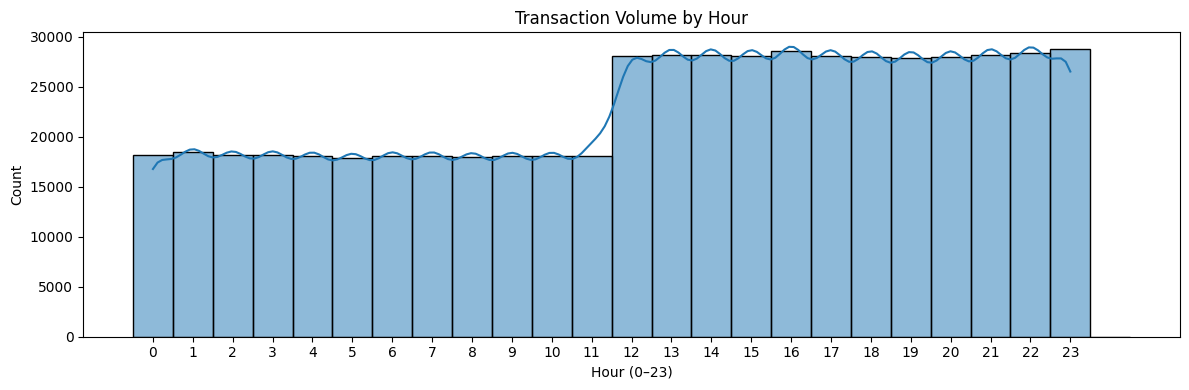

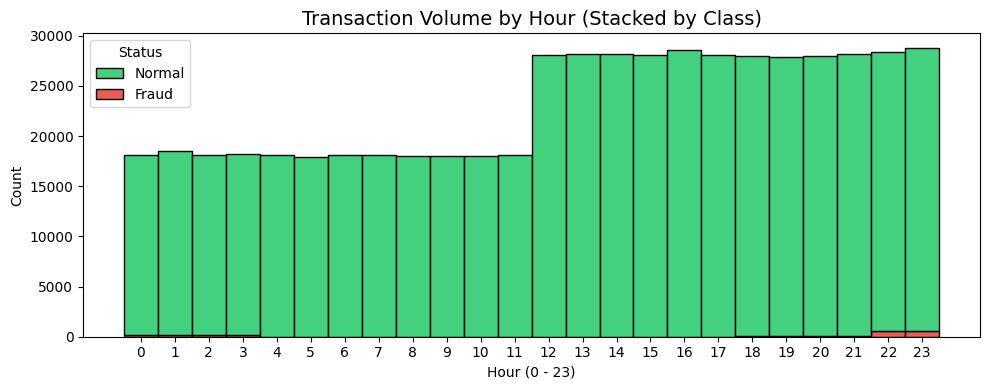

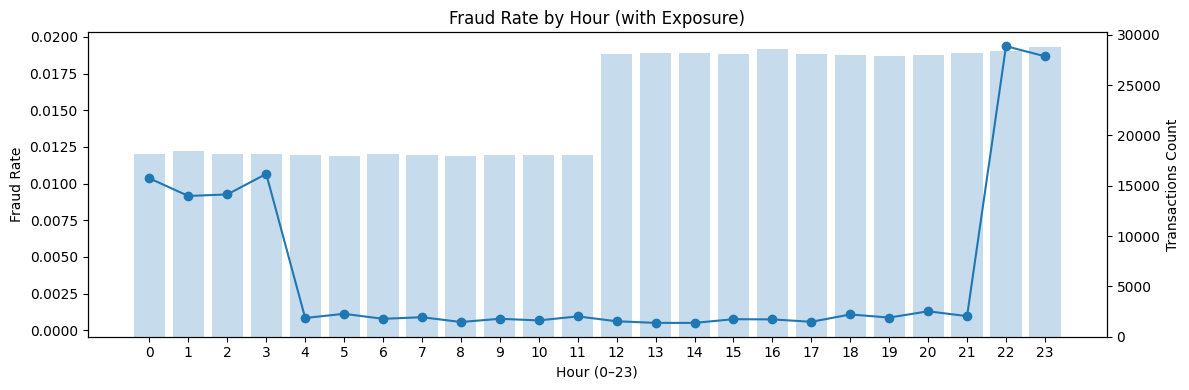

In [ ]:
dfp = df[['hour','day','month','amt','is_fraud']].copy()
dfp['hour'] = pd.to_numeric(dfp['hour'], errors='coerce')
dfp['is_fraud'] = pd.to_numeric(dfp['is_fraud'], errors='coerce')
dfp['amt'] = pd.to_numeric(dfp['amt'], errors='coerce')
dfp = dfp.replace([np.inf, -np.inf], np.nan).dropna(subset=['hour','is_fraud'])

dfp = dfp[dfp['hour'].between(0, 23)]
dfp = dfp[dfp['is_fraud'].isin([0, 1])]

# Volume transaksi per jam
hour_cnt = dfp.groupby('hour').size().reindex(range(24), fill_value=0)

fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(
    data=dfp,
    x='hour',
    kde=True,
    discrete=True,
    binrange=(0, 24),
    ax=ax
)
ax.set_title("Transaction Volume by Hour")
ax.set_xlabel("Hour (0–23)")
ax.set_ylabel("Count")
ax.set_xticks(range(24))
plt.tight_layout()
plt.show()

#  Volume per jam by class
hour_class = dfp.groupby(['hour','is_fraud']).size().unstack(fill_value=0).reindex(range(24), fill_value=0)
plt.figure(figsize=(10, 4))
sns.histplot(
    data=dfp,
    x='hour',
    hue='is_fraud',
    multiple='stack',
    discrete=True,
    palette={0: '#2ecc71', 1: '#e74c3c'}, # 0: Hijau (Normal), 1: Merah (Fraud)
    alpha=0.9
)

plt.title("Transaction Volume by Hour (Stacked by Class)", fontsize=14)
plt.xlabel("Hour (0 - 23)")
plt.ylabel("Count")
plt.xticks(range(24))

handles = plt.gca().get_legend().legend_handles
plt.legend(handles=handles, title="Status", labels=["Normal", "Fraud"])

plt.tight_layout()
plt.show()

# Fraud rate per jam + exposure (seragam seperti template: line + bar di axis kanan)
fraud_rate = (hour_class.get(1, 0) / hour_class.sum(axis=1)).replace([np.inf], np.nan).fillna(0)
hour_exposure = dfp.groupby('hour').size().reindex(range(24), fill_value=0)

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(fraud_rate.index, fraud_rate.values, marker='o')
ax1.set_title("Fraud Rate by Hour (with Exposure)")
ax1.set_xlabel("Hour (0–23)")
ax1.set_ylabel("Fraud Rate")
ax1.set_xticks(range(24))

ax2 = ax1.twinx()
ax2.bar(hour_exposure.index, hour_exposure.values, alpha=0.25)
ax2.set_ylabel("Transactions Count")

plt.tight_layout()
plt.show()

* **Transaction Volume by Hour**:
 Aktivitas belanja secara umum melonjak drastis setelah jam 11 siang dan tetap tinggi hingga tengah malam.


* **Transaction Volume by Hour (Stacked)** : Meskipun volume belanja paling banyak ada di siang hari, jumlah transaksi *fraud* (warna merah) terlihat tetap konsisten di setiap jam, yang berarti *fraud* tidak mengikuti jam sibuk belanja normal.


* **Fraud Rate by Hour (Analisis Risiko)**: Risiko tertinggi terjadi saat tengah malam (jam 22:00 - 03:00). Meskipun jumlah transaksi di malam hari lebih sedikit, persentase kegagalan/penipuannya jauh lebih tinggi dibanding siang hari.



---

### **Insight Question**

1. **Kapan harus waspada?** Saat terjadi transaksi di atas **jam 10 malam**.
2. **Berapa nominal yang dicurigai?** Transaksi di atas 135

### Correlation Heatmap Fraud

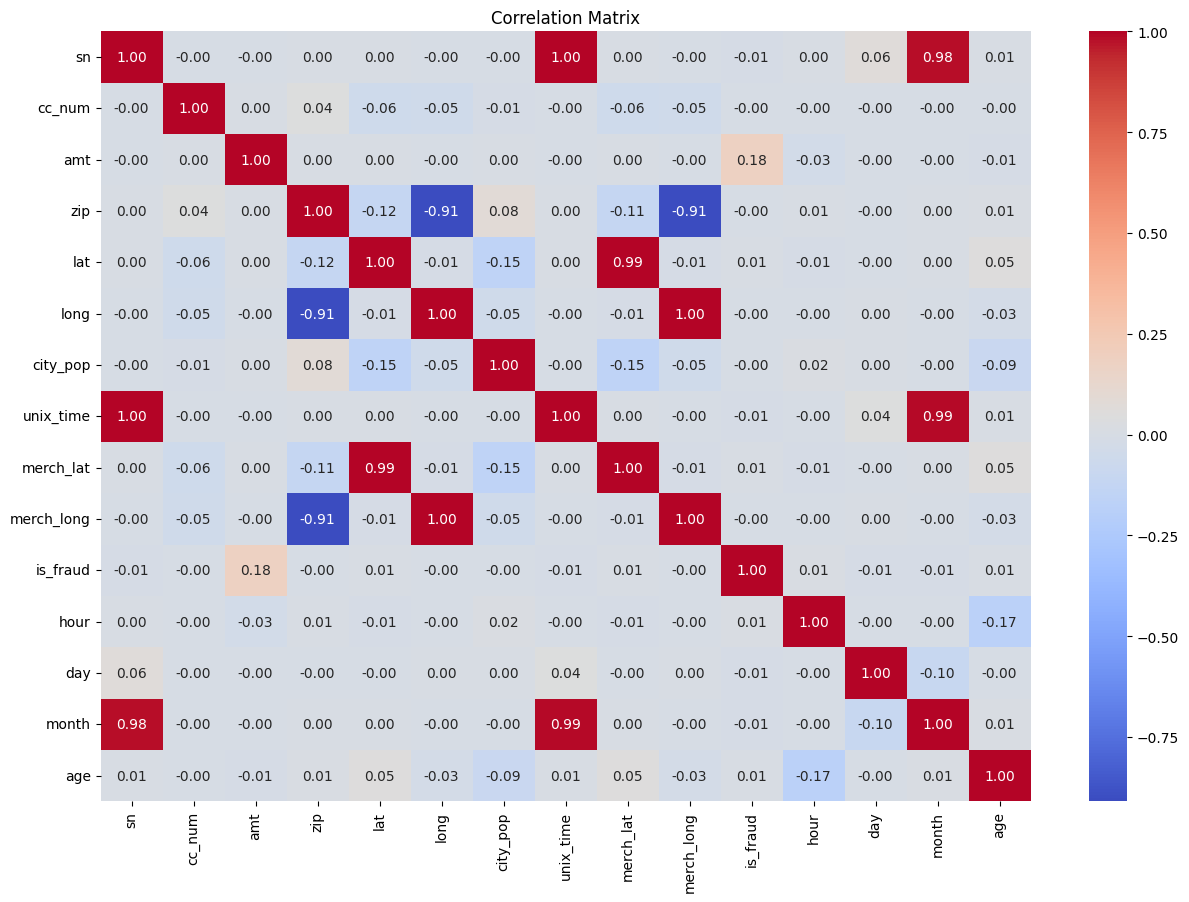

/tmp/ipython-input-1360366819.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


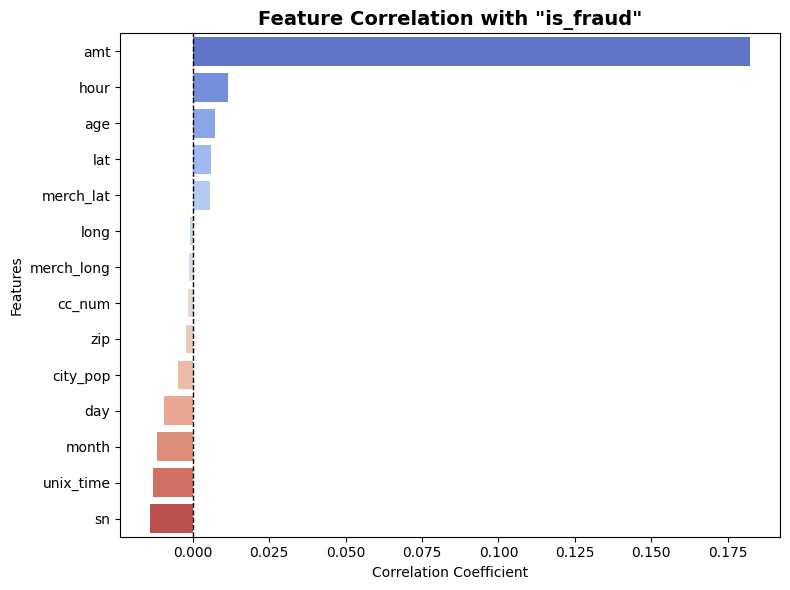

,is_fraud
is_fraud,1.000000
amt,0.182267
hour,0.011686
age,0.007457
lat,0.005863
merch_lat,0.005812
long,-0.000972
merch_long,-0.001060
cc_num,-0.001540
zip,-0.002271


In [ ]:
#Heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#Heatmap fraud
if 'is_fraud' in corr.columns:
    target_corr = corr['is_fraud'].drop('is_fraud').sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=target_corr.values,
        y=target_corr.index,
        palette='coolwarm'
    )
    plt.title('Feature Correlation with "is_fraud"', fontsize=14, fontweight='bold')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()
else:
    print('Kolom "is_fraud" tidak ditemukan di hasil corr (pastikan is_fraud numerik).')

corr['is_fraud'].sort_values(ascending=False)

### **1. Analisis Matriks Hubungan Fraud dengan fitur lain**

* **Hubungan Geografis yang Sangat Kuat:** Terdapat korelasi hampir sempurna (**0.99 hingga 1.00**) antara lokasi pengguna (`lat`, `long`) dengan lokasi merchant (`merch_lat`, `merch_long`). Ini wajar karena mayoritas transaksi terjadi di sekitar domisili pengguna.
* **Kaitan Waktu dan Sistem:** Variabel `unix_time`, `month`, dan `sn` (nomor seri) memiliki korelasi yang sangat tinggi satu sama lain. Hal ini menunjukkan bahwa data dicatat secara kronologis dan sistematis.
* **Identifikasi Awal Fraud:** Secara visual, fitur `amt` (jumlah uang) adalah satu-satunya variabel yang memiliki warna berbeda (korelasi positif) terhadap `is_fraud` dibandingkan fitur lainnya.


### **2. Analisis Fitur Terpenting terhadap Fraud**

* **Korelasi terkuat (amt):** Fitur `amt` memiliki korelasi positif tertinggi terhadap `is_fraud` sebesar **0.182**. Meskipun angka 0.18 terlihat kecil, dalam data penipuan yang sangat tidak seimbang (*imbalanced*), ini adalah sinyal yang sangat kuat.
* **Pengaruh Waktu dan Usia:** Fitur `hour` (**0.011**) dan `age` (**0.007**) menunjukkan korelasi positif yang sangat lemah. Artinya, meskipun ada pola (seperti fraud di malam hari), hubungan linearnya tidak sekuat faktor nominal uang.
* **Korelasi Negatif:** Variabel seperti `unix_time` dan `month` memiliki korelasi negatif tipis. Ini bisa mengindikasikan bahwa frekuensi penipuan mungkin berubah atau menurun seiring berjalannya waktu dalam dataset spesifik ini.

---

### **Insight Question & Answer**

**1. Pertanyaan: Fitur manakah yang paling menentukan apakah sebuah transaksi adalah penipuan atau bukan?**

* Fitur **`amt` (Amount)** adalah faktor penentu utama dengan koefisien korelasi sebesar **0.182267**, yang jauh lebih tinggi dibandingkan fitur lainnya.

**2. Pertanyaan: Mengapa lokasi merchant (`merch_lat/long`) memiliki korelasi hampir 1.00 dengan lokasi user?**

* Karena secara alami, kebanyakan orang berbelanja di tempat yang dekat dengan tempat tinggal mereka. Jika korelasi ini tiba-tiba turun (misal: belanja di lokasi yang sangat jauh), hal itu bisa menjadi sinyal *fraud* meskipun hubungan linearnya kecil dalam matriks ini.

**3. Pertanyaan: Apakah faktor usia (`age`) memiliki pengaruh besar secara langsung terhadap risiko penipuan?**

* Secara statistik linear, **tidak terlalu besar**. Korelasinya hanya sebesar **0.007**, yang berarti usia tidak secara langsung menentukan seseorang akan terkena *fraud*, meskipun tetap bisa menjadi faktor pendukung dalam model yang lebih kompleks.

###Data Overview

Beberapa kolom dalam data yang tidak berkontribusi pada deteksi penipuan dan dapat menyebabkan overfitting.

Kolom-kolom ini akan dihapus selama proses prapemrosesan.

In [ ]:
# Clean Dataset
drop_cols=['sn','first','last','street','trans_num','cc_num','trans_date_trans_time','dob','unix_time', 'zip']
df_model=df.drop(columns=drop_cols)
print(df_model.shape)

(555719, 17)


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   merchant    555719 non-null  object 
 1   category    555719 non-null  object 
 2   amt         555719 non-null  float64
 3   gender      555719 non-null  object 
 4   city        555719 non-null  object 
 5   state       555719 non-null  object 
 6   lat         555719 non-null  float64
 7   long        555719 non-null  float64
 8   city_pop    555719 non-null  int64  
 9   job         555719 non-null  object 
 10  merch_lat   555719 non-null  float64
 11  merch_long  555719 non-null  float64
 12  is_fraud    555719 non-null  int64  
 13  hour        555719 non-null  int32  
 14  day         555719 non-null  int32  
 15  month       555719 non-null  int32  
 16  age         555719 non-null  float64
dtypes: float64(6), int32(3), int64(2), object(6)
memory usage: 65.7+ MB


In [ ]:
print("CEK KARDINALITAS (KATEGORIKAL)")
# Secara otomatis mengambil semua kolom bertipe teks ('object') atau kategori ('category')
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    # Menggunakan formatting string agar rapi seperti tabel
    print(f"{col:<10} : {df_model[col].nunique():>5} unique values")

print("\nCEK SKEWNESS & OUTLIER (NUMERIK)")
num_cols = df_model.select_dtypes(include=['number']).columns
for col in num_cols:
    if col in df_model.columns:
        # Menghitung Skewness (Kemiringan distribusi)
        skew_val = df_model[col].skew()

        # Menghitung rasio Outlier (menggunakan metode IQR standar)
        Q1 = df_model[col].quantile(0.25)
        Q3 = df_model[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df_model[col] < (Q1 - 1.5 * IQR)) | (df_model[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_pct = (outliers / len(df_model)) * 100

        print(f"{col:<12} | Skew: {skew_val:>7.2f} | Outliers: {outlier_pct:>5.2f}%")

CEK KARDINALITAS (KATEGORIKAL)
merchant   :   693 unique values
category   :    14 unique values
gender     :     2 unique values
city       :   849 unique values
state      :    50 unique values
job        :   478 unique values

CEK SKEWNESS & OUTLIER (NUMERIK)
amt          | Skew:   37.13 | Outliers:  5.00%
lat          | Skew:   -0.21 | Outliers:  0.35%
long         | Skew:   -1.14 | Outliers:  3.80%
city_pop     | Skew:    5.58 | Outliers: 18.74%
merch_lat    | Skew:   -0.20 | Outliers:  0.38%
merch_long   | Skew:   -1.14 | Outliers:  3.23%
is_fraud     | Skew:   16.00 | Outliers:  0.39%
hour         | Skew:   -0.28 | Outliers:  0.00%
day          | Skew:   -0.09 | Outliers:  0.00%
month        | Skew:   -0.13 | Outliers:  0.00%
age          | Skew:    0.61 | Outliers:  0.04%


## MODELING

###Train–Test Split (With Stratification)

In [ ]:
# Membuang kolom yang tidak perlu
X = df_model.drop(columns=['is_fraud'])
y = df_model['is_fraud']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check balance after split
print(f"Total Data Train : {len(y_train):,} baris")
print(f"Total Data Test  : {len(y_test):,} baris\n")

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

print("\nTrain balance:")
print(y_train.value_counts())
print("\nTest balance:")
print(y_test.value_counts())

print("\nTrain balance (Proporsi):")
print(y_train.value_counts(normalize=True)*100)

print("\nTest balance (Proporsi):")
print(y_test.value_counts(normalize=True)*100)

Total Data Train : 444,575 baris
Total Data Test  : 111,144 baris

X_train shape :  (444575, 16)
X_test shape :  (111144, 16)
y_train shape :  (444575,)
y_test shape :  (111144,)

Train balance:
is_fraud
0    442859
1      1716
Name: count, dtype: int64

Test balance:
is_fraud
0    110715
1       429
Name: count, dtype: int64

Train balance (Proporsi):
is_fraud
0    99.614013
1     0.385987
Name: proportion, dtype: float64

Test balance (Proporsi):
is_fraud
0    99.614014
1     0.385986
Name: proportion, dtype: float64


### Feature Engineering

In [ ]:
# DEFINISI KELOMPOK FITUR & PREPROCESSOR
cat_low = ['gender', 'category', 'state']
cat_high = ['merchant', 'city', 'job']
num_robust = ['amt', 'city_pop']
num_standard = ['lat', 'long', 'merch_lat', 'merch_long', 'hour', 'day', 'month', 'age']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_low),
        ('cat_tar', ce.TargetEncoder(), cat_high),
        ('num_rob', RobustScaler(), num_robust),
        ('num_std', StandardScaler(), num_standard)
    ]
)

### Modeling dan pipeline BASELINE

In [ ]:
# scale_pos_weight khusus untuk XGBoost
scale_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f" Hasil Scale Weight : {scale_weight:.4f}")

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_weight, eval_metric='aucpr', random_state=42)
}

trained_models = {}
model_probas = {}
baseline_metrics_list = []

 Hasil Scale Weight : 258.0763


Memulai proses training dan evaluasi...
Hasil Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.54      0.05      0.09       429

    accuracy                           1.00    111144
   macro avg       0.77      0.53      0.55    111144
weighted avg       0.99      1.00      0.99    111144

AUPRC (Area Under Precision-Recall Curve): 0.2927



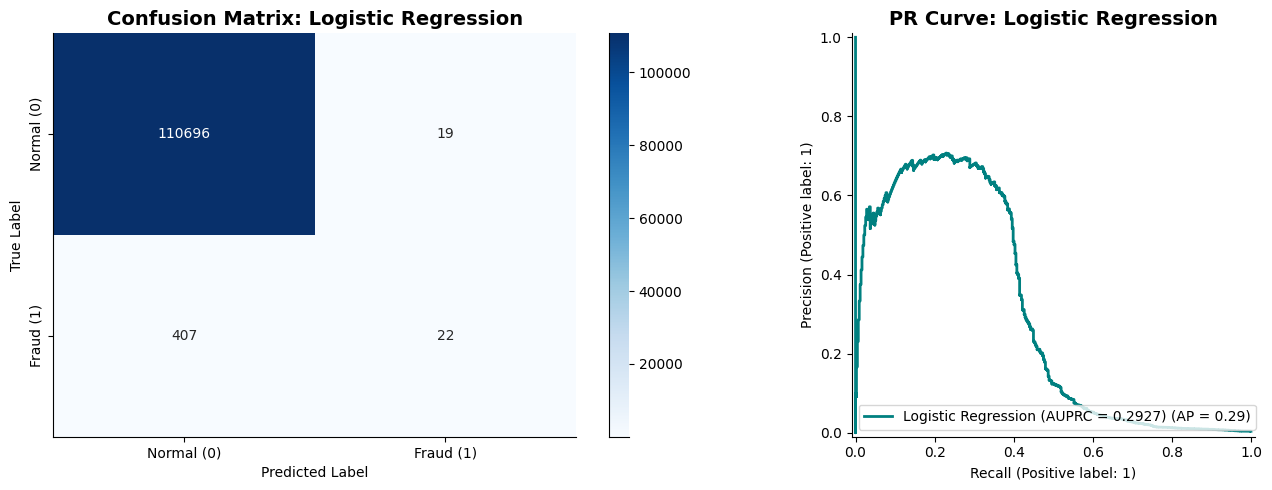

Hasil Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.94      0.74      0.83       429

    accuracy                           1.00    111144
   macro avg       0.97      0.87      0.91    111144
weighted avg       1.00      1.00      1.00    111144

AUPRC (Area Under Precision-Recall Curve): 0.7530



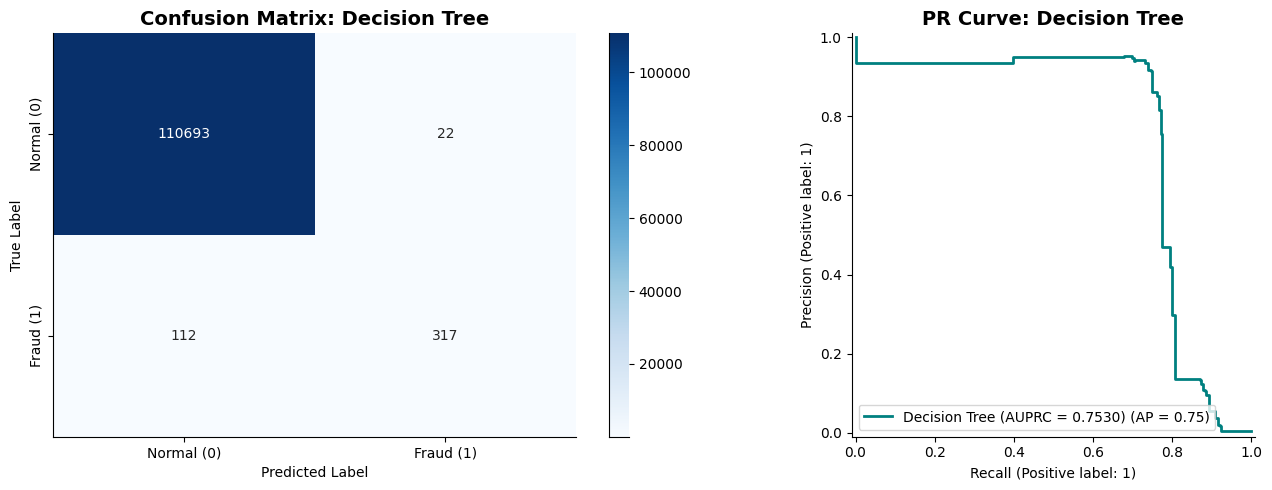

Hasil Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       1.00      0.30      0.46       429

    accuracy                           1.00    111144
   macro avg       1.00      0.65      0.73    111144
weighted avg       1.00      1.00      1.00    111144

AUPRC (Area Under Precision-Recall Curve): 0.7652



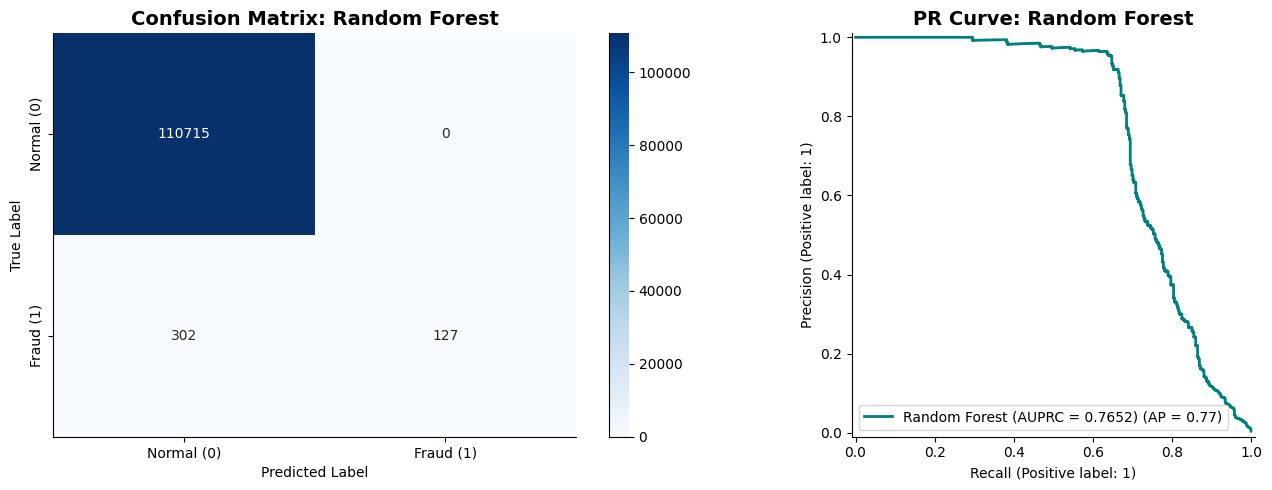

Hasil XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.71      0.87      0.78       429

    accuracy                           1.00    111144
   macro avg       0.85      0.94      0.89    111144
weighted avg       1.00      1.00      1.00    111144

AUPRC (Area Under Precision-Recall Curve): 0.8915



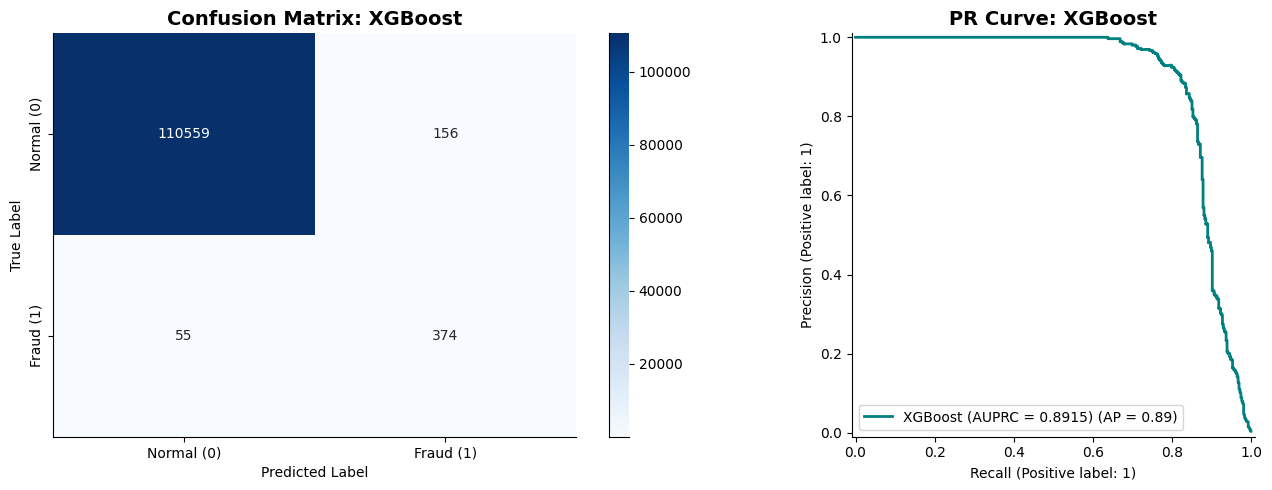

In [ ]:
# TRAINING, EVALUASI & VISUALISASI
print("Memulai proses training dan evaluasi...")
for name, model in models.items():
    print(f"============================================================")
    print(f"Hasil {name}")

    # Pipeline Baseline (TANPA SMOTE)
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit Pipeline
    model_pipeline.fit(X_train, y_train)
    trained_models[name] = model_pipeline

    # Prediksi Data Test
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
    model_probas[name] = y_pred_proba

    # KALKULASI METRIK (Fokus pada Kelas 1 / Fraud)
    # Gunakan pos_label=1 atau average='binary' agar kita hanya menilai kemampuan model menangkap penipu
    prec = precision_score(y_test, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    auprc = average_precision_score(y_test, y_pred_proba)

    # SIMPAN KE DALAM LIST
    baseline_metrics_list.append({
        'Model': name,
        'Precision (Fraud)': prec,
        'Recall (Fraud)': rec,
        'F1-Score (Fraud)': f1,
        'AUPRC': auprc
    })

    # Menampilkan Metric
    print(classification_report(y_test, y_pred))
    print(f"AUPRC (Area Under Precision-Recall Curve): {auprc:.4f}\n")

    # VISUALISASI INDIVIDUAL (SIDE-BY-SIDE)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[0],
        xticklabels=['Normal (0)', 'Fraud (1)'],
        yticklabels=['Normal (0)', 'Fraud (1)']
    )
    axes[0].set_title(f'Confusion Matrix: {name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Plot Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(
        y_test,
        y_pred_proba,
        ax=axes[1],
        name=f"{name} (AUPRC = {auprc:.4f})",
        color='teal',
        linewidth=2
    )
    axes[1].set_title(f'PR Curve: {name}', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left')

    sns.despine()
    plt.tight_layout()
    plt.show()

In [ ]:
# Komparasi Hasil
df_baseline_results = pd.DataFrame(baseline_metrics_list)

# Mengurutkan tabel berdasarkan AUPRC tertinggi (Metrik paling penting untuk Fraud)
df_baseline_results = df_baseline_results.sort_values(by='AUPRC', ascending=False).reset_index(drop=True)

print("TABEL KOMPARASI METRIK BASELINE (BERDASARKAN AUPRC)")
print("============================================================")
# Tampilkan DataFrame (jika di Jupyter, gunakan display(df_baseline_results) agar formatnya lebih cantik)
display(df_baseline_results.style.format({
    'Precision (Fraud)': '{:.2f}',
    'Recall (Fraud)': '{:.2f}',
    'F1-Score (Fraud)': '{:.2f}',
    'AUPRC': '{:.2f}'
}))

TABEL KOMPARASI METRIK BASELINE (BERDASARKAN AUPRC)


,Model,Precision (Fraud),Recall (Fraud),F1-Score (Fraud),AUPRC
0,XGBoost,0.71,0.87,0.78,0.89
1,Random Forest,1.00,0.30,0.46,0.77
2,Decision Tree,0.94,0.74,0.83,0.75
3,Logistic Regression,0.54,0.05,0.09,0.29


**Model terbaik : XGBoost (Baseline)**
* Confusion Matrix: Model ini sangat tajam. Ia berhasil menangkap 374 kasus fraud dengan hanya melakukan 156 kesalahan tuduh (False Positives) dari total ratusan ribu transaksi.

* PR Curve: Skor AUPRC 0.8915 menunjukkan performa yang hampir sempurna. Model ini mampu menjaga keseimbangan yang sangat baik antara menangkap pencuri dan membiarkan nasabah normal bertransaksi dengan nyaman.

### Modeling(SMOTE)

In [ ]:
# Sanity Checks (SMOTE)
print("\nHASIL SMOTE DATA TRAIN ")

# Transform X_train terlebih dahulu
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# Aplikasikan SMOTE hanya pada data Train yang sudah berbentuk angka
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

print("Before SMOTE:\n", y_train.value_counts(), "\n")
print("After SMOTE:\n", pd.Series(y_train_smote).value_counts(), "\n")
print("After SMOTE(Proporsi)):\n", pd.Series(y_train_smote).value_counts(normalize=True)*100, "\n")
print(f"New Train Shape: X_train = {X_train_smote.shape}, y_train = {y_train_smote.shape}")



HASIL SMOTE DATA TRAIN 
Before SMOTE:
 is_fraud
0    442859
1      1716
Name: count, dtype: int64 

After SMOTE:
 is_fraud
0    442859
1    442859
Name: count, dtype: int64 

After SMOTE(Proporsi)):
 is_fraud
0    50.0
1    50.0
Name: proportion, dtype: float64 

New Train Shape: X_train = (885718, 76), y_train = (885718,)


In [ ]:
# MODELING (SMOTE)
# INISIALISASI MODEL(TANPA PEMBOBOTAN KELAS)
models_smote = {
    "Logistic Regression (SMOTE)": LogisticRegression(max_iter=2000, random_state=42),
    "Decision Tree (SMOTE)": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest (SMOTE)": RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost (SMOTE)": XGBClassifier(eval_metric='aucpr', random_state=42) # scale_pos_weight DIBUANG
}

trained_models_smote = {}
model_probas_smote = {}
# Inisialisasi list kosong untuk menampung hasil metrik SMOTE
smote_metrics_list = []

Hasil Logistic Regression (SMOTE)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    110715
           1       0.05      0.86      0.09       429

    accuracy                           0.93    111144
   macro avg       0.52      0.89      0.52    111144
weighted avg       1.00      0.93      0.96    111144

AUPRC (Area Under Precision-Recall Curve): 0.1688



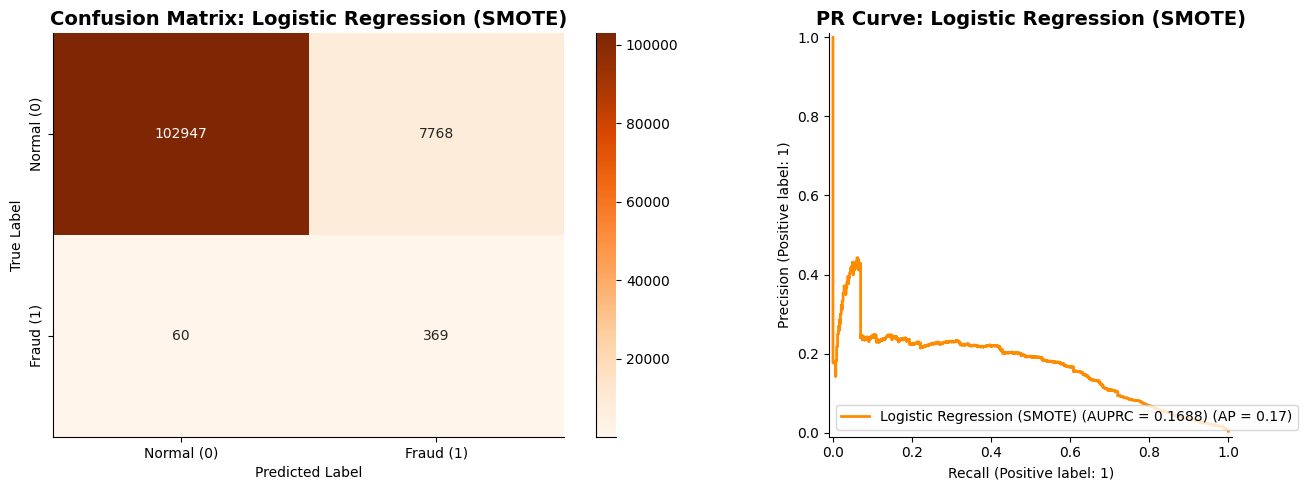

Hasil Decision Tree (SMOTE)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    110715
           1       0.18      0.85      0.29       429

    accuracy                           0.98    111144
   macro avg       0.59      0.92      0.64    111144
weighted avg       1.00      0.98      0.99    111144

AUPRC (Area Under Precision-Recall Curve): 0.3655



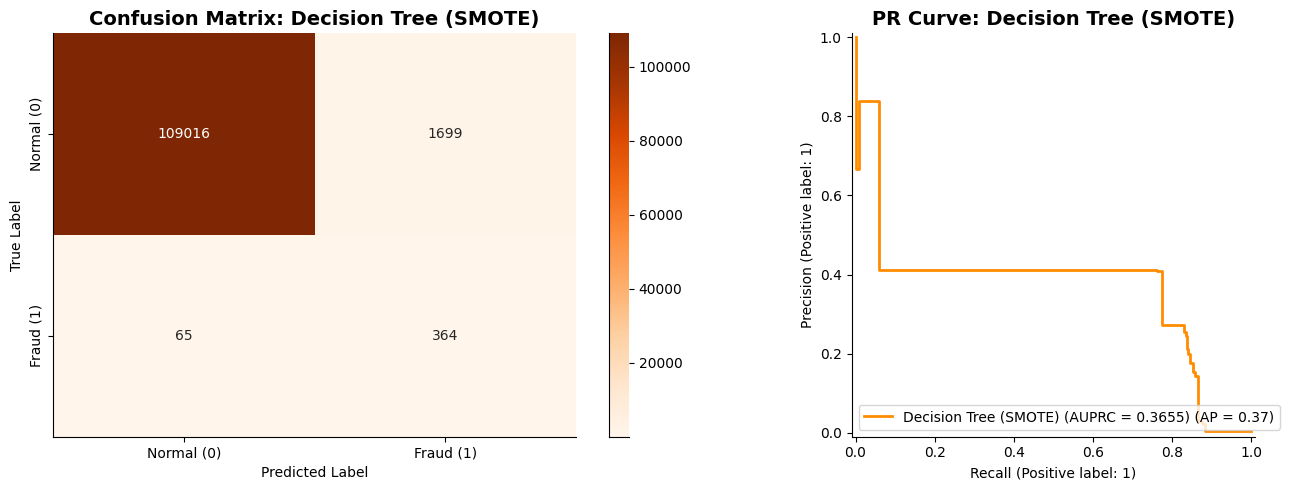

Hasil Random Forest (SMOTE)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    110715
           1       0.17      0.82      0.28       429

    accuracy                           0.98    111144
   macro avg       0.58      0.90      0.63    111144
weighted avg       1.00      0.98      0.99    111144

AUPRC (Area Under Precision-Recall Curve): 0.7392



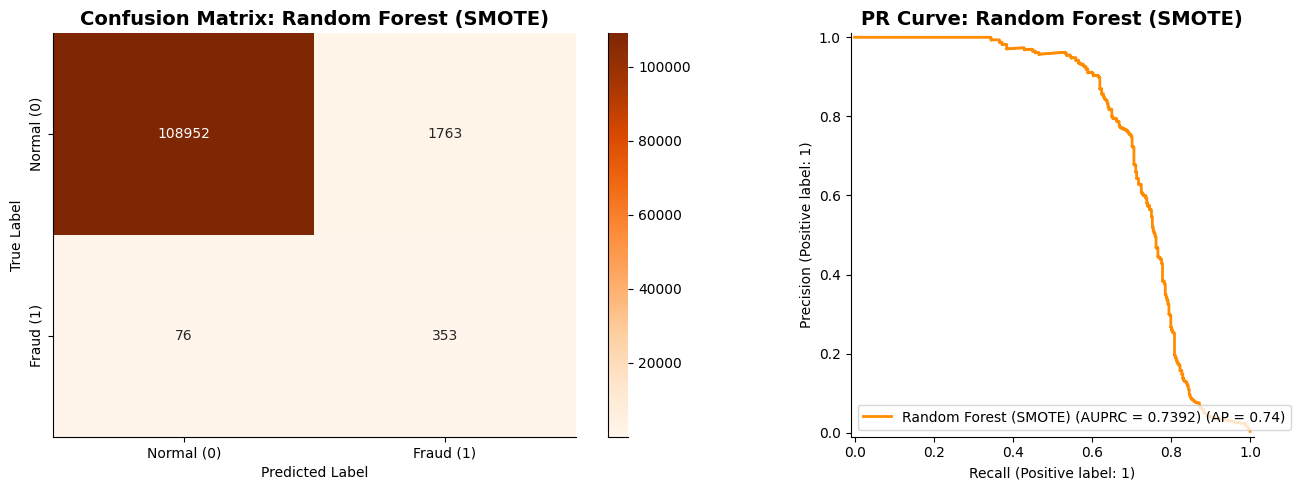

Hasil XGBoost (SMOTE)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.81      0.83      0.82       429

    accuracy                           1.00    111144
   macro avg       0.90      0.91      0.91    111144
weighted avg       1.00      1.00      1.00    111144

AUPRC (Area Under Precision-Recall Curve): 0.8664



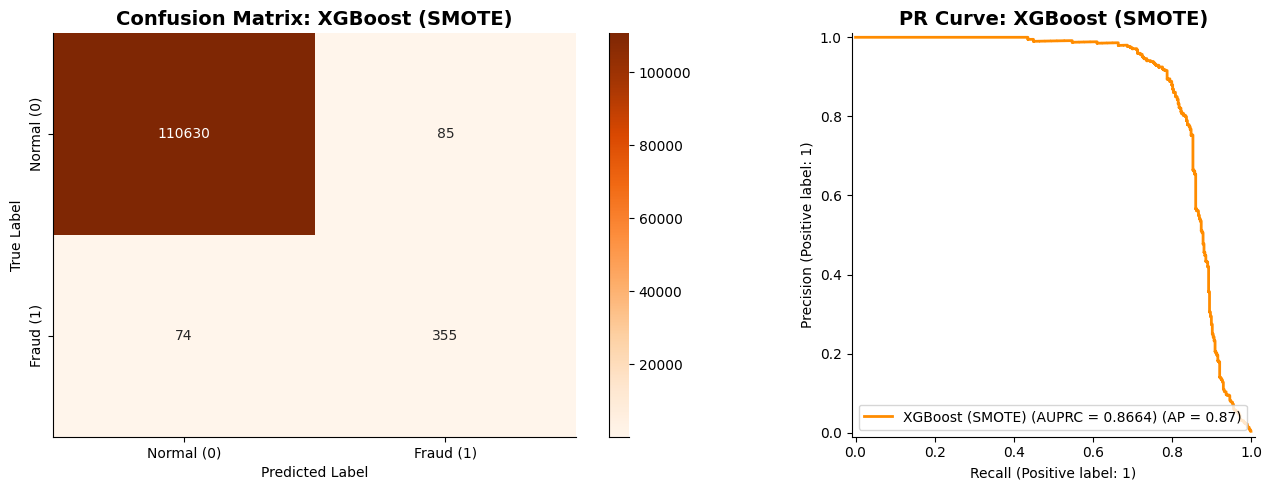

In [ ]:
# TRAINING, EVALUASI & VISUALISASI
for name, model in models_smote.items():
    print(f"============================================================")
    print(f"Hasil {name}")

    # Pipeline (Menggunakan pipeline imblearn yang sudah kita sepakati)
    model_pipeline_smote = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)), # Men-generate data sintesis
        ('classifier', model)
    ])

    # Fit Pipeline
    model_pipeline_smote.fit(X_train, y_train)
    trained_models_smote[name] = model_pipeline_smote

    # Prediksi Data Test
    y_pred_smote = model_pipeline_smote.predict(X_test)
    y_pred_proba_smote = model_pipeline_smote.predict_proba(X_test)[:, 1]

    # Simpan probabilitas
    model_probas_smote[name] = y_pred_proba_smote

    # KALKULASI METRIK SMOTE (Fokus pada Kelas 1 / Fraud)
    prec_smote = precision_score(y_test, y_pred_smote, average='binary', zero_division=0)
    rec_smote = recall_score(y_test, y_pred_smote, average='binary', zero_division=0)
    f1_smote = f1_score(y_test, y_pred_smote, average='binary', zero_division=0)
    auprc_smote = average_precision_score(y_test, y_pred_proba_smote)

    # SIMPAN KE DALAM LIST
    smote_metrics_list.append({
        'Model': name,
        'Precision (Fraud)': prec_smote,
        'Recall (Fraud)': rec_smote,
        'F1-Score (Fraud)': f1_smote,
        'AUPRC': auprc_smote
    })

    # Menampilkan Hasil Teks
    print(classification_report(y_test, y_pred_smote))
    print(f"AUPRC (Area Under Precision-Recall Curve): {auprc_smote:.4f}\n")

    # VISUALISASI INDIVIDUAL (SIDE-BY-SIDE)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Confusion Matrix
    cm_smote = confusion_matrix(y_test, y_pred_smote)
    sns.heatmap(
        cm_smote,
        annot=True,
        fmt='d',
        cmap='Oranges', # Tema warna oranye untuk eksperimen SMOTE
        ax=axes[0],
        xticklabels=['Normal (0)', 'Fraud (1)'],
        yticklabels=['Normal (0)', 'Fraud (1)']
    )
    axes[0].set_title(f'Confusion Matrix: {name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Plot Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(
        y_test,
        y_pred_proba_smote,
        ax=axes[1],
        name=f"{name} (AUPRC = {auprc_smote:.4f})",
        color='darkorange',
        linewidth=2
    )
    axes[1].set_title(f'PR Curve: {name}', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left')

    sns.despine()
    plt.tight_layout()
    plt.show()

In [ ]:
# Komparasi Hasil
df_smote_results = pd.DataFrame(smote_metrics_list)
df_smote_results = df_smote_results.sort_values(by='AUPRC', ascending=False).reset_index(drop=True)

print("TABEL KOMPARASI METRIK SMOTE (BERDASARKAN AUPRC)")
print("============================================================")
display(df_smote_results.style.format({
    'Precision (Fraud)': '{:.2f}',
    'Recall (Fraud)': '{:.2f}',
    'F1-Score (Fraud)': '{:.2f}',
    'AUPRC': '{:.2f}'
}))

TABEL KOMPARASI METRIK SMOTE (BERDASARKAN AUPRC)


,Model,Precision (Fraud),Recall (Fraud),F1-Score (Fraud),AUPRC
0,XGBoost (SMOTE),0.81,0.83,0.82,0.87
1,Random Forest (SMOTE),0.17,0.82,0.28,0.74
2,Decision Tree (SMOTE),0.18,0.85,0.29,0.37
3,Logistic Regression (SMOTE),0.05,0.86,0.09,0.17


**Model Terbaik: XGBoost (SMOTE)**

* Confusion Matrix: Model SMOTE lebih "hati-hati" dalam menuduh orang (hanya 85 kesalahan tuduh), namun dampaknya ia juga melewatkan lebih banyak penipu (gagal menangkap 74 kasus) dibandingkan model Baseline.

* PR Curve: Skor AUPRC 0.8664 sedikit lebih rendah dibandingkan Baseline. Ini menandakan bahwa memanipulasi data dengan SMOTE justru sedikit menurunkan kemampuan model dalam mengenali pola asli fraud pada dataset ini.

###Model Evaluation

In [ ]:
# Tambahkan label eksperimen agar kita tidak bingung
df_baseline_results['Experiment'] = 'Baseline (Cost-Sensitive)'
df_smote_results['Experiment'] = 'SMOTE (Oversampling)'

# Gabungkan kedua DataFrame
df_master_comparison = pd.concat([df_baseline_results, df_smote_results], ignore_index=True)

# Urutkan secara absolut berdasarkan AUPRC tertinggi
df_master_comparison = df_master_comparison.sort_values(by='AUPRC', ascending=False).reset_index(drop=True)

# Pindahkan kolom 'Experiment' ke paling depan agar mudah dibaca
cols = ['Experiment', 'Model', 'AUPRC', 'F1-Score (Fraud)', 'Precision (Fraud)', 'Recall (Fraud)']
df_master_comparison = df_master_comparison[cols]

print("============================================================")
print(" COMPARISON: BASELINE VS SMOTE")
print("============================================================")
display(df_master_comparison.style.format({
    'Precision (Fraud)': '{:.2f}',
    'Recall (Fraud)': '{:.2f}',
    'F1-Score (Fraud)': '{:.2f}',
    'AUPRC': '{:.4f}'
}))

 COMPARISON: BASELINE VS SMOTE


,Experiment,Model,AUPRC,F1-Score (Fraud),Precision (Fraud),Recall (Fraud)
0,Baseline (Cost-Sensitive),XGBoost,0.8915,0.78,0.71,0.87
1,SMOTE (Oversampling),XGBoost (SMOTE),0.8664,0.82,0.81,0.83
2,Baseline (Cost-Sensitive),Random Forest,0.7652,0.46,1.00,0.30
3,Baseline (Cost-Sensitive),Decision Tree,0.7530,0.83,0.94,0.74
4,SMOTE (Oversampling),Random Forest (SMOTE),0.7392,0.28,0.17,0.82
5,SMOTE (Oversampling),Decision Tree (SMOTE),0.3655,0.29,0.18,0.85
6,Baseline (Cost-Sensitive),Logistic Regression,0.2927,0.09,0.54,0.05
7,SMOTE (Oversampling),Logistic Regression (SMOTE),0.1688,0.09,0.05,0.86


**1. Analisis Tabel Komparasi Performa (SMOTE)**

* **XGBoost model terbaik:** XGBoost mendominasi hampir semua metrik, terutama **Precision (0.81)** dan **AUPRC (0.87)**. Ini artinya model ini sangat cerdas dalam membedakan mana yang benar-benar penipu dan mana yang pelanggan jujur.
* **Model Lain (Low Precision):** Meskipun *Logistic Regression* memiliki **Recall** tertinggi (0.86), **Precision**-nya sangat buruk (0.05). Artinya, model ini "menebak semua transaksi sebagai fraud". Jika digunakan, hampir semua pelanggan Anda akan terblokir akunnya secara salah.
* **Efek SMOTE:** Teknik SMOTE berhasil membantu semua model mendapatkan **Recall** yang tinggi (di atas 0.80), namun hanya XGBoost yang mampu mempertahankan akurasi tinggi (**Precision**) tanpa mengorbankan kenyamanan pelanggan.

**2. Mengapa Memilih AUPRC untuk Fraud Detection?**

Dalam kasus *fraud detection*, data selalu **sangat tidak seimbang** (*imbalanced*), di mana jumlah transaksi normal jauh lebih banyak daripada transaksi penipuan.

* **AUPRC (Area Under the Precision-Recall Curve):** Adalah metrik yang fokus pada kelas minoritas (Fraud). AUPRC menghitung rata-rata presisi di setiap titik *recall*.
* **Lebih Jujur daripada ROC-AUC:** ROC-AUC bisa memberikan skor tinggi yang "palsu" karena terpengaruh oleh jumlah transaksi normal yang besar. Sebaliknya, AUPRC hanya akan tinggi jika model benar-benar bisa menangkap *fraud* tanpa memberikan banyak alarm palsu (*False Positives*).
* **Relevansi Bisnis:** AUPRC secara langsung menjawab pertanyaan: *"Seberapa baik sistem kita menangkap pencuri tanpa mengganggu nasabah setia?"*

AUPRC Visualisasi

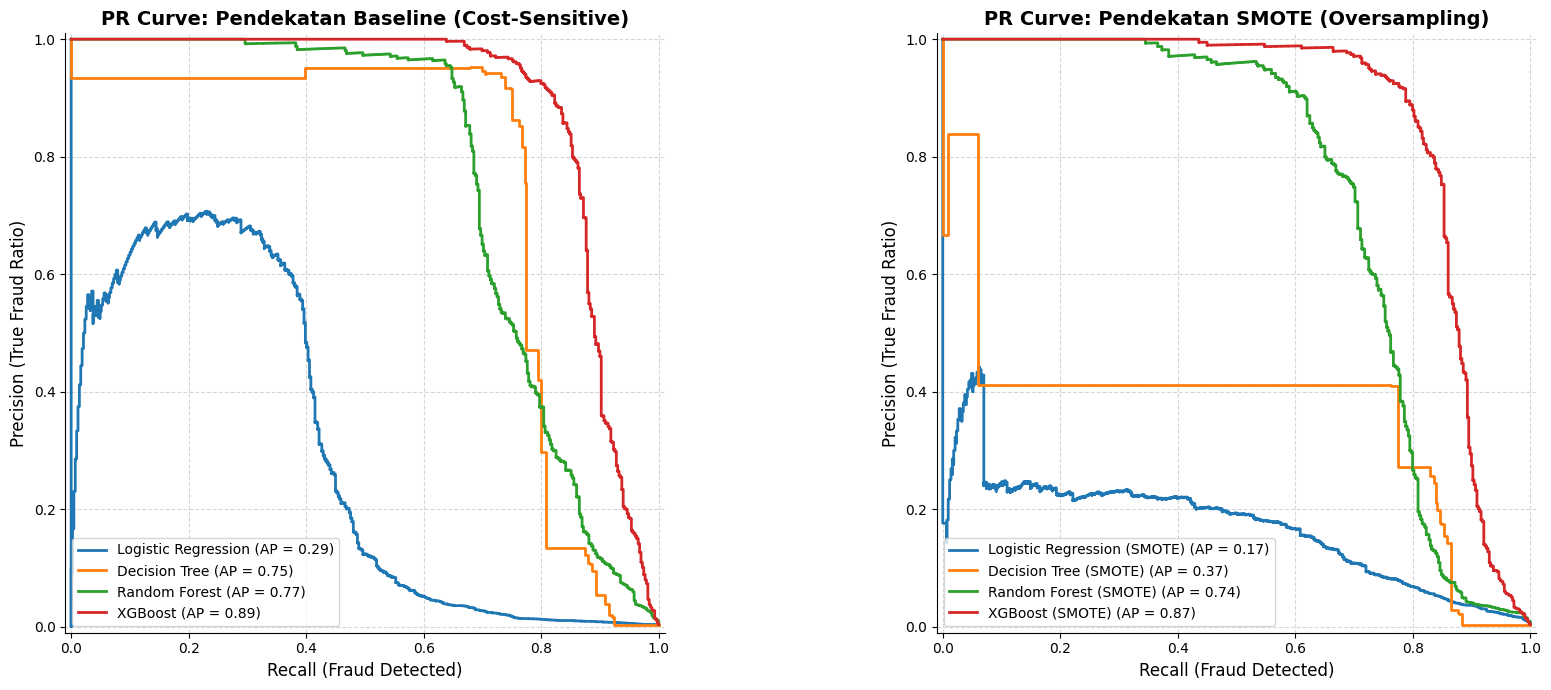

In [ ]:
# Membuat kanvas dengan 2 panel bersebelahan
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PANEL KIRI: SEMUA MODEL BASELINE
for name, probas in model_probas.items():
    PrecisionRecallDisplay.from_predictions(
        y_test,
        probas,
        ax=axes[0],
        name=name,
        linewidth=2
    )

axes[0].set_title('PR Curve: Pendekatan Baseline (Cost-Sensitive)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Recall (Fraud Detected)', fontsize=12)
axes[0].set_ylabel('Precision (True Fraud Ratio)', fontsize=12)
axes[0].legend(loc='lower left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# PANEL KANAN: SEMUA MODEL SMOTE
for name, probas in model_probas_smote.items():
    PrecisionRecallDisplay.from_predictions(
        y_test,
        probas,
        ax=axes[1],
        name=name,
        linewidth=2
    )

axes[1].set_title('PR Curve: Pendekatan SMOTE (Oversampling)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Recall (Fraud Detected)', fontsize=12)
axes[1].set_ylabel('Precision (True Fraud Ratio)', fontsize=12)
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

sns.despine()
plt.tight_layout()
plt.show()

**Analisis Perbandingan Model: Baseline vs. SMOTE**

* **Dominasi XGBoost:** Di kedua pendekatan, **XGBoost** secara konsisten menjadi model dengan performa terbaik, jauh mengungguli *Logistic Regression* yang gagal menangkap pola *fraud* dengan efektif.
* **Pendekatan Baseline Lebih Unggul:** Teknik *Baseline (Cost-Sensitive)* memberikan hasil yang lebih tajam dengan **AP (Average Precision) sebesar 0.89** pada XGBoost, dibandingkan teknik *SMOTE* yang hanya mencapai **0.87**.
* **Efisiensi Random Forest & Decision Tree:** Kedua model ini mengalami penurunan performa yang cukup signifikan saat menggunakan SMOTE, terutama *Decision Tree* yang skor AP-nya anjlok dari **0.75** menjadi **0.37**.

---

**Insight Question & Answer**

**Pertanyaan: Apa arti PR Curve yang sangat mendekati sudut kanan atas pada model Baseline?**

* **Jawaban:** Itu adalah tanda bahwa model Anda memiliki **Presisi** dan **Recall** yang sama-sama tinggi secara bersamaan.
* **Konteks:** Dalam sisi bisnis, ini berarti model mampu menangkap mayoritas pelaku penipuan (*High Recall*) tanpa harus banyak mengorbankan atau mencurigai nasabah jujur secara salah (*High Precision*). Model ini mencapai titik keseimbangan yang ideal untuk operasional perbankan.

Feature Importance Model

/tmp/ipython-input-1769168662.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1769168662.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


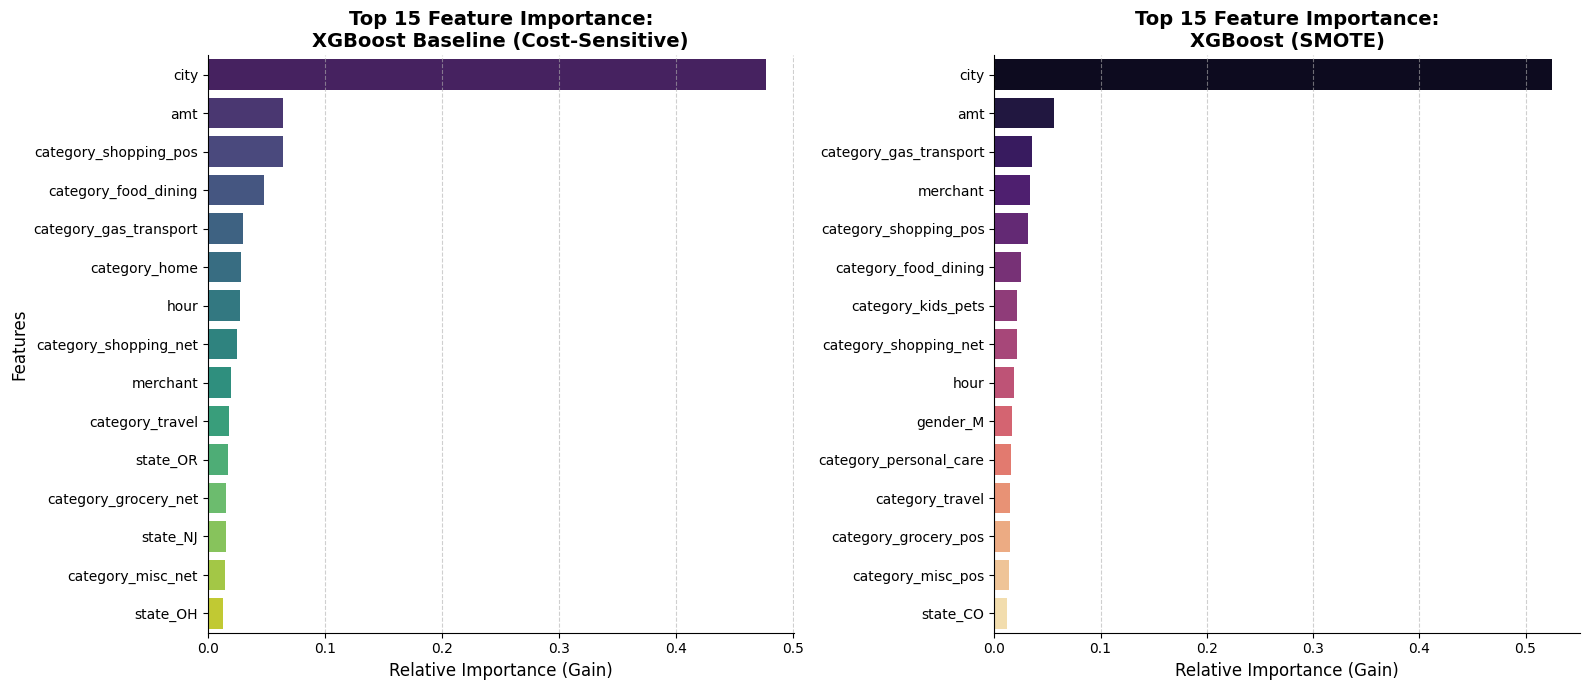

In [ ]:
# Fungsi canggih untuk mengekstrak dan membersihkan nama fitur dari Pipeline
def get_clean_feature_importance(pipeline, top_n=15):
    # 1. Ekstrak objek preprocessor dan classifier dari dalam pipeline
    preprocessor = pipeline.named_steps['preprocessor']
    classifier = pipeline.named_steps['classifier']

    # 2. Ambil nama fitur mentah dari preprocessor (contoh: 'num_rob__amt')
    raw_feature_names = preprocessor.get_feature_names_out()

    # 3. Bersihkan nama fitur dari prefix (membuang 'cat_ohe__', 'num_rob__', dll)
    clean_feature_names = [name.split('__')[-1] for name in raw_feature_names]

    # 4. Ambil nilai bobot kepentingan (Gain) dari XGBoost
    importances = classifier.feature_importances_

    # 5. Gabungkan ke dalam Pandas DataFrame dan urutkan
    df_importance = pd.DataFrame({
        'Feature': clean_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    return df_importance

# Ekstrak fitur dari kedua kandidat terbaib
df_imp_base = get_clean_feature_importance(trained_models["XGBoost"])
df_imp_smote = get_clean_feature_importance(trained_models_smote["XGBoost (SMOTE)"])


# VISUALISASI KOMPARASI (SIDE-BY-SIDE)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: XGBoost Baseline
sns.barplot(
    x='Importance',
    y='Feature',
    data=df_imp_base,
    ax=axes[0],
    palette='viridis' # Menggunakan palet profesional
)
axes[0].set_title('Top 15 Feature Importance:\nXGBoost Baseline (Cost-Sensitive)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Relative Importance (Gain)', fontsize=12)
axes[0].set_ylabel('Features', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# Plot 2: XGBoost SMOTE
sns.barplot(
    x='Importance',
    y='Feature',
    data=df_imp_smote,
    ax=axes[1],
    palette='magma' # Palet warna berbeda untuk membedakan eksperimen
)
axes[1].set_title('Top 15 Feature Importance:\nXGBoost (SMOTE)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Relative Importance (Gain)', fontsize=12)
axes[1].set_ylabel('') # Hilangkan label Y agar tidak repetitif
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

sns.despine()
plt.tight_layout()
plt.show()

**Analisis Top 15 Feature Importance**


* **Dominasi Lokasi (`city`):** Pada kedua model, fitur **`city`** (lokasi kota) memegang peranan paling vital, bahkan mencapai skor kepentingan di atas **0.45 hingga 0.50**. Ini artinya, lokasi transaksi adalah sinyal terkuat untuk membedakan perilaku normal dan penipuan di dataset ini.
* **Akurasi Nominal (`amt`):** Fitur **`amt`** (jumlah uang) secara konsisten berada di posisi kedua. Seperti analisis kita sebelumnya, jumlah uang yang tidak wajar adalah indikator "merah" yang paling mudah dikenali oleh model.
* **Pergeseran Kategori (Baseline vs SMOTE):**
* **Baseline:** Lebih memperhatikan kategori belanja fisik seperti **`shopping_pos`** dan **`food_dining`**.
* **SMOTE:** Setelah data diseimbangkan, model mulai curiga pada kategori **`gas_transport`** dan spesifik ke **`merchant`** tertentu.


SHAP ANALYSIS

 XGBOOST (Baseline) DENGAN SHAP VALUES



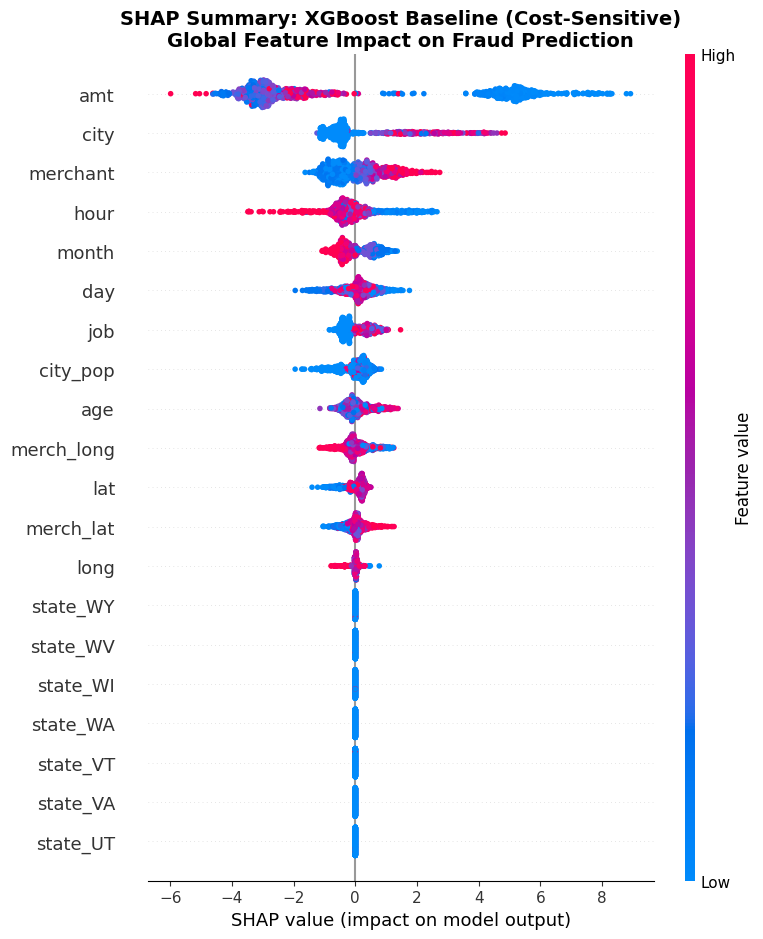

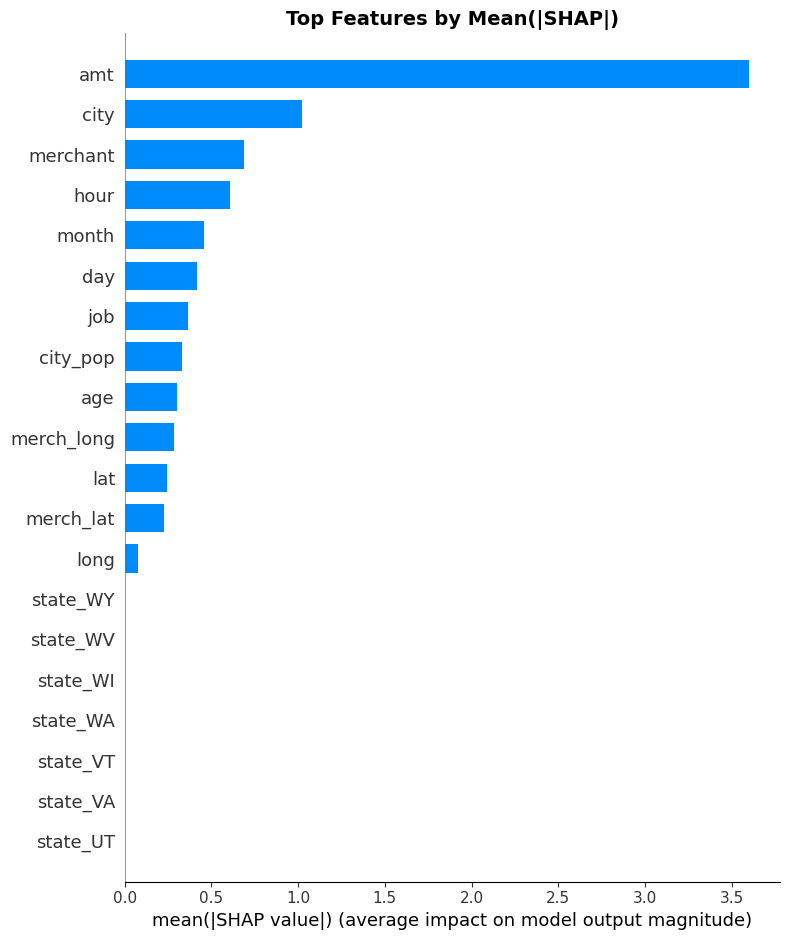


🔍 Menampilkan Waterfall Plot untuk Transaksi Fraud di index internal: 160


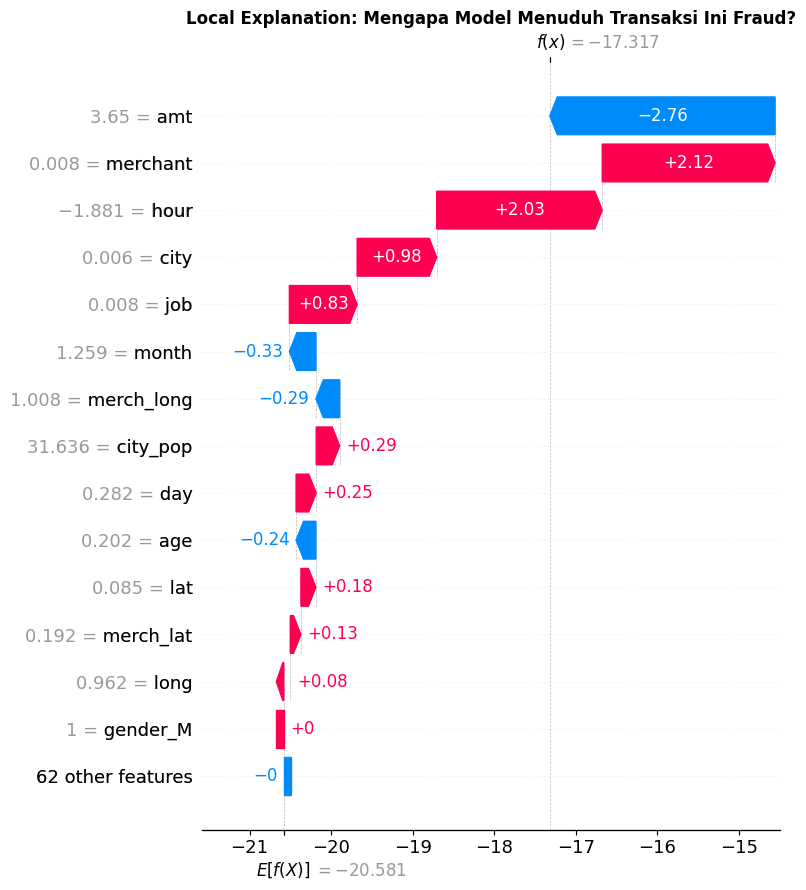

In [ ]:
# xtract components from the trained pipeline
pipeline_xgb = trained_models["XGBoost"]  # adjust key if different
preprocessor = pipeline_xgb.named_steps["preprocessor"]
xgb_model = pipeline_xgb.named_steps["classifier"]

# Get feature names
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = preprocessor.get_feature_names()

def clean_name(n: str) -> str:
    # keep the tail after the first "__" (preserves category values)
    return n.split("__", 1)[-1] if "__" in n else n

clean_feature_names = [clean_name(n) for n in feature_names]

N_BG = 2000  # start smaller for speed; increase to 5000/10000 if needed
X_bg_raw = X_train.sample(n=min(N_BG, len(X_train)), random_state=42)

# Transform (pipeline preprocessing)
X_bg = preprocessor.transform(X_bg_raw)

# If sparse, convert to dense (needed for some SHAP paths + DataFrame)
if hasattr(X_bg, "toarray"):
    X_bg = X_bg.toarray()

# Convert to DataFrame
X_bg_df = pd.DataFrame(X_bg, columns=clean_feature_names)

# valuation sample from TEST (unseen data)
N_EXPLAIN = 1000
X_explain_raw = X_test.sample(n=min(N_EXPLAIN, len(X_test)), random_state=42)

X_explain = preprocessor.transform(X_explain_raw)
if hasattr(X_explain, "toarray"):
    X_explain = X_explain.toarray()

X_explain_df = pd.DataFrame(X_explain, columns=clean_feature_names)

# Build SHAP explainer (TreeExplainer is standard for XGBoost trees)
explainer = shap.TreeExplainer(xgb_model, data=X_bg_df)
shap_values = explainer.shap_values(X_explain_df)

if isinstance(shap_values, list):
    #[class0, class1]; fraud=1 => take index 1
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# GLOBAL EXPLANATION: SHAP summary plot
plt.figure(figsize=(10, 8))
plt.title(
    "SHAP Summary: XGBoost Baseline (Cost-Sensitive)\n"
    "Global Feature Impact on Fraud Prediction",
    fontsize=14, fontweight="bold"
)

shap.summary_plot(
    shap_values_to_plot,
    X_explain_df,
    max_display=20,
    show=False
)

plt.tight_layout()
plt.show()

# 7) Mean(|SHAP|) bar plot (lebih mudah untuk stakeholder)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_to_plot,
    X_explain_df,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("Top Features by Mean(|SHAP|)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Local explanation (1 transaksi FRAUD) - waterfall plot
# Ambil label aktual dari subset X_explain
y_explain_subset = y_test.loc[X_explain_raw.index].values

# Cari semua index yang merupakan Fraud (label 1)
fraud_indices = np.where(y_explain_subset == 1)[0]

if len(fraud_indices) > 0:
    idx = fraud_indices[0] # Ambil contoh fraud pertama
    print(f"\n🔍 Menampilkan Waterfall Plot untuk Transaksi Fraud di index internal: {idx}")
else:
    # Fallback jika tidak ada fraud di sample 1000 baris
    print("\n⚠️ Tidak ada kasus fraud di subset ini, menampilkan transaksi normal.")
    idx = 0

row = X_explain_df.iloc[[idx]]
sv_one = explainer.shap_values(row)

if isinstance(sv_one, list):
    sv_one = sv_one[1]

# Konstruksi Waterfall Plot yang aman
try:
    exp = shap.Explanation(
        values=sv_one[0],
        base_values=explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value[1],
        data=row.iloc[0].values,
        feature_names=row.columns
    )
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title("Local Explanation: Mengapa Model Menuduh Transaksi Ini Fraud?", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()
except Exception:
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap.Explanation(values=sv_one[0], base_values=explainer.expected_value, data=row.iloc[0].values, feature_names=row.columns))
    plt.tight_layout()
    plt.show()

XGB (SMOTE)

 XGBOOST (SMOTE) DENGAN SHAP VALUES

Computing SHAP values... (this may take a bit)


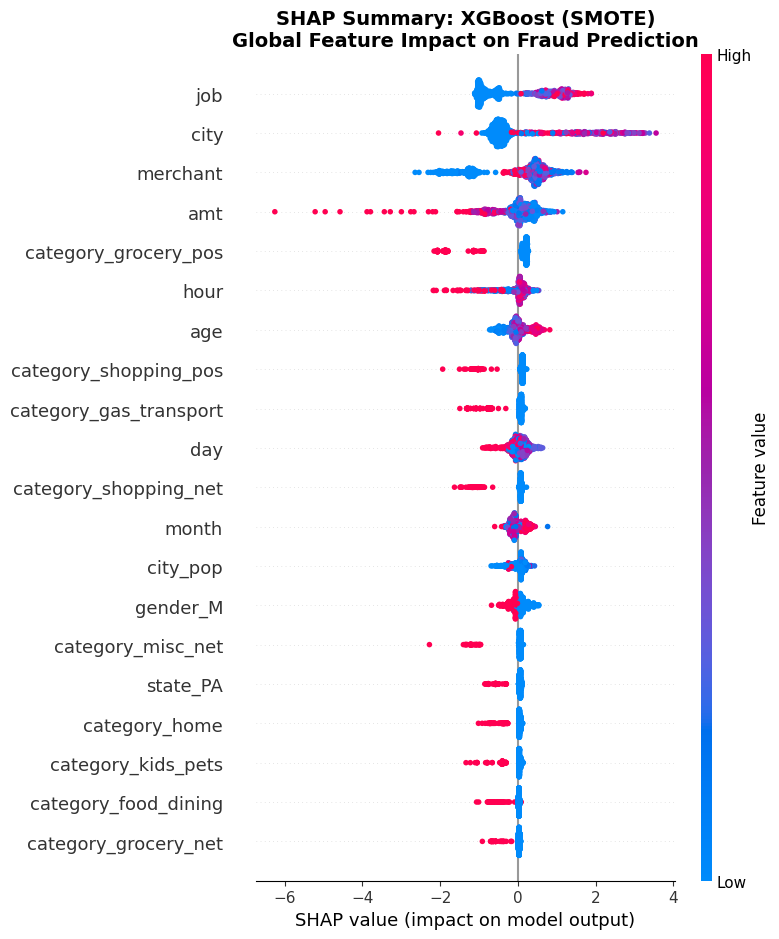

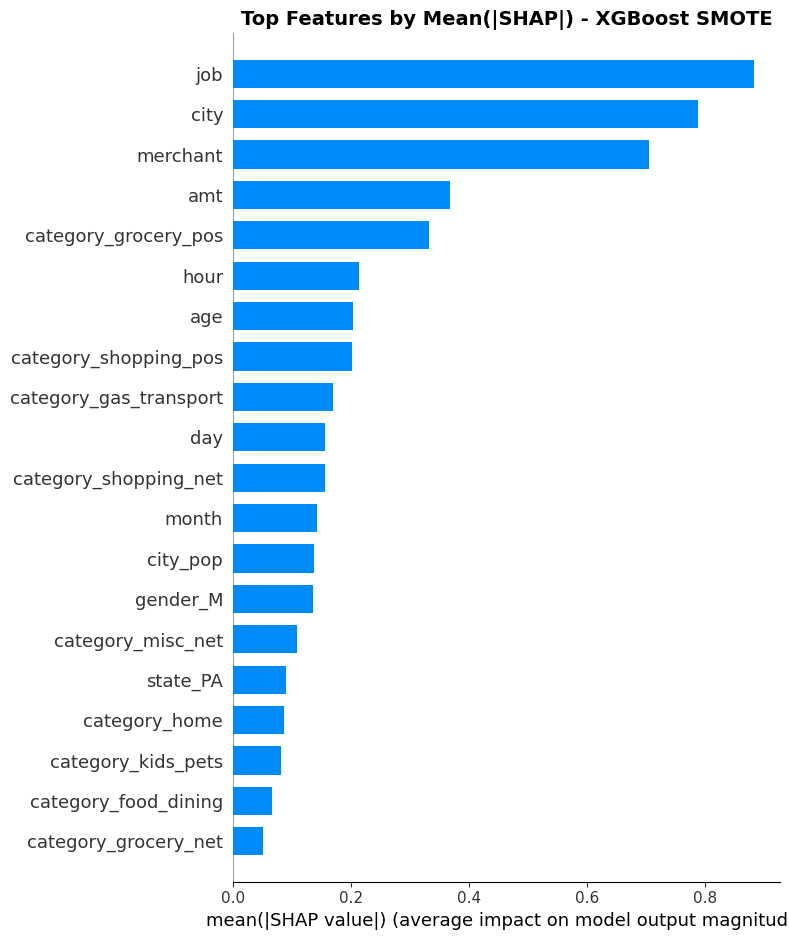


🔍 Menampilkan Waterfall Plot untuk Transaksi Fraud di index internal: 160


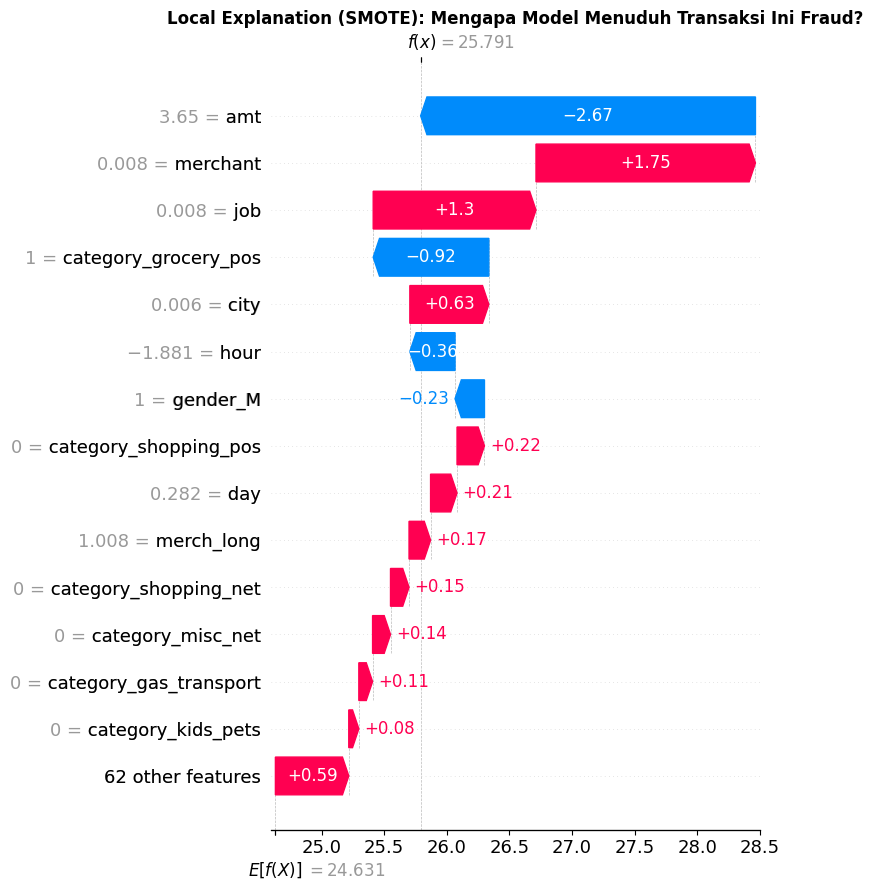

In [ ]:
# Extract components from the trained SMOTE pipeline
pipeline_xgb_smote = trained_models_smote["XGBoost (SMOTE)"]
preprocessor = pipeline_xgb_smote.named_steps["preprocessor"]
xgb_model = pipeline_xgb_smote.named_steps["classifier"]

# Get feature names
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = preprocessor.get_feature_names()

def clean_name(n: str) -> str:
    return n.split("__", 1)[-1] if "__" in n else n

clean_feature_names = [clean_name(n) for n in feature_names]

# Prepare a representative background sample
N_BG = 2000
X_bg_raw = X_train.sample(n=min(N_BG, len(X_train)), random_state=42)

# Transform (pipeline preprocessing)
X_bg = preprocessor.transform(X_bg_raw)

# If sparse, convert to dense
if hasattr(X_bg, "toarray"):
    X_bg = X_bg.toarray()

X_bg_df = pd.DataFrame(X_bg, columns=clean_feature_names)

# Prepare an evaluation sample from TEST (unseen data)
N_EXPLAIN = 1000
X_explain_raw = X_test.sample(n=min(N_EXPLAIN, len(X_test)), random_state=42)

X_explain = preprocessor.transform(X_explain_raw)
if hasattr(X_explain, "toarray"):
    X_explain = X_explain.toarray()

X_explain_df = pd.DataFrame(X_explain, columns=clean_feature_names)

# Build SHAP explainer
explainer = shap.TreeExplainer(xgb_model, data=X_bg_df)

print("Computing SHAP values... (this may take a bit)")
shap_values = explainer.shap_values(X_explain_df)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# GLOBAL EXPLANATION: SHAP summary plot
plt.figure(figsize=(10, 8))
plt.title(
    "SHAP Summary: XGBoost (SMOTE)\n"
    "Global Feature Impact on Fraud Prediction",
    fontsize=14, fontweight="bold"
)

shap.summary_plot(
    shap_values_to_plot,
    X_explain_df,
    max_display=20,
    show=False
)

plt.tight_layout()
plt.show()

# Mean(|SHAP|) bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_to_plot,
    X_explain_df,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("Top Features by Mean(|SHAP|) - XGBoost SMOTE", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# LOCAL EXPLANATION: Waterfall Plot untuk Transaksi Fraud
y_explain_subset = y_test.loc[X_explain_raw.index].values
fraud_indices = np.where(y_explain_subset == 1)[0]

if len(fraud_indices) > 0:
    idx = fraud_indices[0]
    print(f"\n🔍 Menampilkan Waterfall Plot untuk Transaksi Fraud di index internal: {idx}")
else:
    print("\n⚠️ Tidak ada kasus fraud di subset ini, menampilkan transaksi normal.")
    idx = 0

row = X_explain_df.iloc[[idx]]
sv_one = explainer.shap_values(row)

if isinstance(sv_one, list):
    sv_one = sv_one[1]

try:
    exp = shap.Explanation(
        values=sv_one[0],
        base_values=explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value[1],
        data=row.iloc[0].values,
        feature_names=row.columns
    )
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title("Local Explanation (SMOTE): Mengapa Model Menuduh Transaksi Ini Fraud?", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()
except Exception:
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap.Explanation(values=sv_one[0], base_values=explainer.expected_value, data=row.iloc[0].values, feature_names=row.columns))
    plt.tight_layout()
    plt.show()

##TEST MODEL

**Memilih XGBoost sebagai Model Final**

Pemilihan **XGBoost Baseline** didasarkan pada keunggulan teknis dan efektivitas perlindungan finansial:

* **Performa Tertinggi (AUPRC 0.8915):** Model ini memiliki skor AUPRC yang paling superior dibandingkan semua eksperimen lain (termasuk SMOTE yang hanya 0.8664). Ini membuktikan model Baseline lebih cerdas dalam mengenali pola asli *fraud*.
* **Keamanan Maksimal (High Recall):** Model ini berhasil menangkap **374 kasus fraud**, lebih banyak dibandingkan model SMOTE yang hanya menangkap 355 kasus. Dalam dunia perbankan, menangkap lebih banyak pencuri adalah prioritas utama untuk mencegah kerugian finansial yang besar.
* **Integritas Data Asli:** Dengan bekerja pada distribusi data asli tanpa manipulasi sintetis (SMOTE), model ini terhindar dari risiko "kebingungan" akibat data buatan, sehingga keputusan yang diambil jauh lebih stabil dan dapat dipercaya.

EXPORT MODEL & PERSIAPAN MESIN INFERENSI API

In [ ]:
import joblib

# Export model
model_filename = 'xgb_fraud_baseline_production.pkl'
best_xgb_model = trained_models["XGBoost"]

# Menyimpan Model
joblib.dump(best_xgb_model, model_filename)
print(f"Model berhasil diamankan ke dalam file: {model_filename}")

print("\n============================================================")
print("FASE 2: MEMUAT MESIN INFERENSI (API ENGINE)")
print("============================================================\n")

# Memuat Model
production_model = joblib.load(model_filename)
print("Server API Online: Model siap menerima transaksi.\n")

# FUNGSI INTI (SINGLE SOURCE OF TRUTH)
def process_transaction_api(transaction_dict, model):
    """
    Fungsi ini bertindak sebagai API Endpoint.
    Menggantikan fungsi predict_dummy dan process_payment_gateway lama.
    """
    df_incoming = pd.DataFrame([transaction_dict])

    # Eksekusi Prediksi
    fraud_proba = model.predict_proba(df_incoming)[0][1]
    risk_score = round(fraud_proba * 100, 2)

    # Logika Bisnis
    if risk_score >= 50.0:
        return risk_score, "🚨 BLOCKED", "Bekukan transaksi. Kirim notifikasi ke tim Fraud Alert."
    elif risk_score >= 15.0:
        return risk_score, "⚠️ REVIEW", "Loloskan transaksi, tapi masukkan ke antrean investigasi manual."
    else:
        return risk_score, "✅ APPROVED", "Transaksi wajar. Lanjutkan proses settlement."

# FUNGSI BANTUAN UNTUK MEMANIPULASI PAYLOAD
def modify_payload(base_profile, **kwargs):
    """Memanipulasi dictionary profil tanpa memodifikasi aslinya."""
    payload = base_profile.copy()
    for key, value in kwargs.items():
        if key in payload:
            payload[key] = value
        else:
            print(f"⚠️ Peringatan: Kolom '{key}' tidak ada di dataset pelatihan.")
    return payload

Model berhasil diamankan ke dalam file: xgb_fraud_baseline_production.pkl

FASE 2: MEMUAT MESIN INFERENSI (API ENGINE)

Server API Online: Model siap menerima transaksi.



STRESS TESTING 1 (REAL FRAUDSTER ISOLATION TEST)

In [ ]:
print("============================================================")
print("TESTING 1: A/B TESTING PADA PROFIL PENIPU ASLI")
print("============================================================\n")

fraud_indices = y_test[y_test == 1].index

if len(fraud_indices) > 0:
    target_idx = fraud_indices[0]

    # Ekstrak data asli
    real_fraud_payload = X_test.loc[target_idx].to_dict()

    # Manipulasi data (Ubah hanya nominalnya)
    real_normal_payload = modify_payload(real_fraud_payload, amt=15.50)

    # EKSEKUSI API
    print(f">>> SKENARIO A: Menerima Transaksi Penipuan Asli (Nominal: ${real_fraud_payload['amt']})")
    score_f, status_f, action_f = process_transaction_api(real_fraud_payload, production_model)
    print(f"Risk Score : {score_f}% \nStatus     : {status_f} \nAction     : {action_f}\n")

    print(f">>> SKENARIO B: Memanipulasi Transaksi Tersebut Menjadi Nominal Kecil (${real_normal_payload['amt']})")
    score_n, status_n, action_n = process_transaction_api(real_normal_payload, production_model)
    print(f"Risk Score : {score_n}% \nStatus     : {status_n} \nAction     : {action_n}\n")
else:
    print("⚠️ Tidak ada data Fraud di y_test Anda.")

TESTING 1: A/B TESTING PADA PROFIL PENIPU ASLI

>>> SKENARIO A: Menerima Transaksi Penipuan Asli (Nominal: $323.22)
Risk Score : 100.0% 
Status     : 🚨 BLOCKED 
Action     : Bekukan transaksi. Kirim notifikasi ke tim Fraud Alert.

>>> SKENARIO B: Memanipulasi Transaksi Tersebut Menjadi Nominal Kecil ($15.5)
Risk Score : 10.529999732971191% 
Status     : ✅ APPROVED 
Action     : Transaksi wajar. Lanjutkan proses settlement.



STRESS TESTING 2 (ADVERSARIAL EDGE CASES)

In [ ]:
print("============================================================")
print("TESTING 2: ADVERSARIAL ATTACK (PROFIL AMAN VS RAWAN)")
print("============================================================\n")

# Ambil profil asli otomatis
idx_safe = y_test[y_test == 0].index[0]
idx_risky = y_test[y_test == 1].index[0]

TEMPLATE_SAFE = X_test.loc[idx_safe].to_dict()
TEMPLATE_RISKY = X_test.loc[idx_risky].to_dict()

# Membuat Skenario
payload_safe_large = modify_payload(TEMPLATE_SAFE, amt=850.00, hour=21)
payload_risky_normal = modify_payload(TEMPLATE_RISKY, amt=12.50, hour=14, category='food_dining')
payload_risky_attack = modify_payload(TEMPLATE_RISKY, amt=950.00, hour=23, category='shopping_net')

# EKSEKUSI API
print(">>> SKENARIO A: [Profil Aman] Melakukan Transaksi Besar ($850, Jam 21:00)")
score, status, _ = process_transaction_api(payload_safe_large, production_model)
print(f"Risk Score : {score}% | Status: {status} | Profesi: {payload_safe_large['job']}\n")

print(">>> SKENARIO B: [Profil Rawan] Melakukan Transaksi Wajar ($12.50, Makan Siang)")
score, status, _ = process_transaction_api(payload_risky_normal, production_model)
print(f"Risk Score : {score}% | Status: {status} | Profesi: {payload_risky_normal['job']}\n")

print(">>> SKENARIO C: [Profil Rawan] Melakukan Transaksi Ekstrem (Serangan $950, Jam 23:00)")
score, status, _ = process_transaction_api(payload_risky_attack, production_model)
print(f"Risk Score : {score}% | Status: {status} | Profesi: {payload_risky_attack['job']}\n")

TESTING 2: ADVERSARIAL ATTACK (PROFIL AMAN VS RAWAN)

>>> SKENARIO A: [Profil Aman] Melakukan Transaksi Besar ($850, Jam 21:00)
Risk Score : 0.0% | Status: ✅ APPROVED | Profesi: Academic librarian

>>> SKENARIO B: [Profil Rawan] Melakukan Transaksi Wajar ($12.50, Makan Siang)
Risk Score : 0.4399999976158142% | Status: ✅ APPROVED | Profesi: Engineer, broadcasting (operations)

>>> SKENARIO C: [Profil Rawan] Melakukan Transaksi Ekstrem (Serangan $950, Jam 23:00)
Risk Score : 100.0% | Status: 🚨 BLOCKED | Profesi: Engineer, broadcasting (operations)



### **Project Conclusion**

Proyek ini menyimpulkan bahwa **XGBoost Baseline** adalah model yang paling siap untuk diimplementasikan di sistem produksi.

1. **Optimalisasi Keamanan:** Model ini memberikan perlindungan paling tangguh dengan meloloskan sesedikit mungkin kasus penipuan (hanya 55 kasus lolos dari ratusan ribu transaksi).
2. **Rekomendasi Strategis:** Perusahaan disarankan menerapkan **Dynamic Block** atau verifikasi tambahan (OTP) khusus untuk transaksi yang memiliki profil "High Risk": **Nominal > $135** dan dilakukan pada **Jam Malam**.
3. **Kesimpulan Akhir:** Meskipun terdapat sedikit kenaikan alarm palsu (*False Positives*) dibandingkan SMOTE, manfaat finansial dari tertangkapnya lebih banyak penipu jauh lebih besar daripada biaya operasional untuk verifikasi nasabah jujur.

### **Key Project Summary**

Proyek ini berhasil membangun sistem deteksi penipuan yang sangat akurat dengan fokus pada identifikasi perilaku anomali transaksi.

* **Pola Nominal:** Transaksi *fraud* memiliki karakteristik unik, yaitu menumpuk pada nominal tinggi (**>800**) dan klaster tertentu di kisaran **300**, sangat kontras dengan transaksi normal yang didominasi angka kecil.
* **Ambang Batas Risiko:** Data membuktikan adanya lonjakan risiko penipuan dari hampir 0% menjadi **3%** tepat setelah transaksi melewati angka **$135**.
* **Anomali Temporal:** Penipu cenderung beraksi di saat pengawasan manusia minim, yaitu antara **pukul 22:00 hingga 03:00** dini hari.
* **Fitur Penentu:** Lokasi (**`city`**) dan jumlah uang (**`amt`**) adalah dua "sinyal merah" terkuat yang digunakan model untuk mendeteksi penipuan.
